## 2 практическое задание по DL

Выполнила: Гайфутдинова Фарида, 317 группа

Тема: Классификация «дотюниным» трансформером

Выбранные архитектуры трансформеров: **BERT, ALBERT**


Задача: Взять несколько предобученных трансоформеров, выбрать одну любую задачу классификации текстов, провести дообучение трансформеров. Разобраться, как их лучше дообучать для получения максимального качества. Для получения максимального качества проводилось варьирование следующих параметров:

1. Batch size
2. LR
3. Tokenizer max length

Датасет: "Twitter US Airline Sentiment"

# Использование трансформера

* на базе https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
* https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [1]:
#!g1.1
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 30.0 MB/s 
     |████████████████████████████████| 596 kB 49.6 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [38]:
#!g1.1
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg', 'pdf']
warnings.filterwarnings('ignore')
from tqdm import tqdm
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Загрузка датасета + его предобработка

In [16]:
#!g1.1
df = pd.read_csv('./Tweets.csv')
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Видим, что метки в неправильном формате, переведем их в нужный - численный.

In [17]:
#!g1.1
def str_to_dig(label):
    if label == 'negative':
        return 0
    elif label == 'positive':
        return 2
    else:
        return 1

In [18]:
#!g1.1
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: str_to_dig(x))
df = df[:8000]
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,2,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Описание датасета

Датасет представляет из себя коллекцию твитов о 6 американских авиакомпаниях. Твиты могут иметь позитивный, негативный, а также нейтральный окрас. (2, 0, 1 соответсвенно)

# BERT
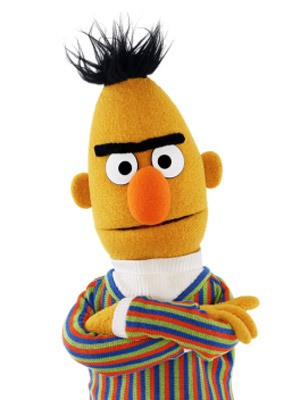


## Архитектура BERT

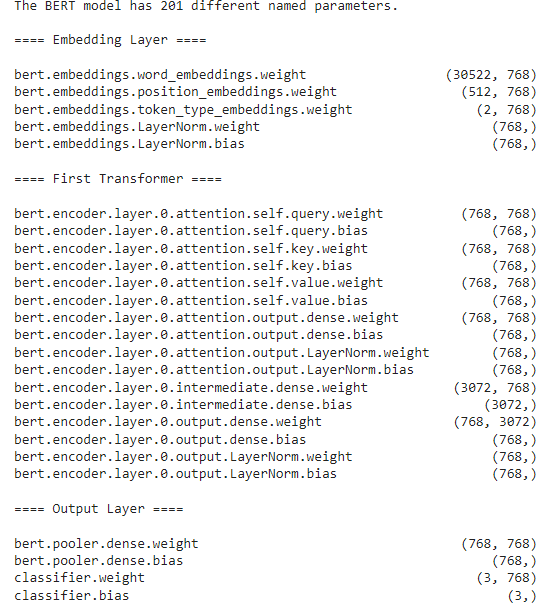

In [ ]:
#!g1.1
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#!g1.1
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [13]:
#!g1.1
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


In [14]:
#!g1.1
sentences = df['text'].to_list()

In [15]:
#!g1.1
labels = df['airline_sentiment'].to_list()

In [ ]:
#!g1.1
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  67


In [ ]:
#!g1.1
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2221: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/kernel/lib/python3.8/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


Original:  @VirginAmerica What @dhepburn said.
Token IDs: tensor([  101,  1030,  6261, 14074, 14735,  2054,  1030, 28144, 13699,  8022,
         2056,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Разбиваем данные на обучение, валидацию и тест

На валидации подбираем гиперпараметры, на тесте сделаем итоговое сравнение

In [ ]:
#!g1.1
import random
from torch.utils.data import TensorDataset, random_split

# Calculate the number of samples to include in each set.
train_and_val_size = int(0.8 * len(input_ids))
train_size = int(0.8 * train_and_val_size)
val_size = train_and_val_size - train_size
test_size = len(input_ids) - train_and_val_size

train_dataset = TensorDataset(input_ids[:train_size], 
                              attention_masks[:train_size], 
                              labels[:train_size])

val_dataset = TensorDataset(input_ids[train_size + 1:train_and_val_size ], 
                            attention_masks[train_size + 1:train_and_val_size], 
                            labels[train_size + 1:train_and_val_size])

test_dataset = TensorDataset(input_ids[train_and_val_size + 1:], 
                             attention_masks[train_and_val_size + 1:], 
                             labels[train_and_val_size + 1:])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

5,120 training samples
1,280 validation samples
1,600 test samples


# Создаем dataloader

In [ ]:
#!g1.1
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
#!g1.1
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
#!g1.1
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [36]:
#!g1.1
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [35]:
#!g1.1
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [40]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Обучаем сеть

In [33]:
#!g1.1
import random
import numpy as np


def train(train_dataloader, validation_dataloader, epochs,
          optimizer, scheduler, model,
          verbose_data=None):
    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    
    if verbose_data is None:
        verbose_data = {
            'train_verbose_steps': [],
            'train_loss': [],
            'test_verbose_steps': [],
            'test_loss': [],
            'test_accuracy': [],
        }

    # For each epoch...
    for epoch_i in tqdm(range(0, epochs)):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            an = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)           
            loss, logits = an['loss'], an['logits']


            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                an = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)            
                loss, logits = an['loss'], an['logits']

                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

#         # Record all statistics from this epoch.
#         training_stats.append(
#             {
#                 'epoch': epoch_i + 1,
#                 'Training Loss': avg_train_loss,
#                 'Valid. Loss': avg_val_loss,
#                 'Valid. Accur.': avg_val_accuracy,
#                 'Training Time': training_time,
#                 'Validation Time': validation_time
#             }
#         )
        
        # save info about test 
        verbose_data['test_verbose_steps'].append(epoch_i + 1)
        verbose_data['test_loss'].append(avg_val_loss)
        verbose_data['test_accuracy'].append(avg_val_accuracy)

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return verbose_data

# Batch size

In [ ]:
#!g1.1
batch_size_list = [16, 32, 48, 64]
test_info = []
epochs = 12

for batch_size in batch_size_list:
    print(f'BATCH_SIZE = {batch_size}')
    train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


    validation_dataloader = DataLoader(
                val_dataset, 
                sampler = SequentialSampler(val_dataset), 
                batch_size = batch_size
            )
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler)
    test_info.append(test_data)

BATCH_SIZE = 16


  0%|          | 0/12 [00:00<?, ?it/s]


======== Epoch 1 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.08
  Training epcoh took: 0:00:25

Running Validation...


  8%|▊         | 1/12 [00:26<04:48, 26.18s/it]

  Accuracy: 0.80
  Validation Loss: 1.05
  Validation took: 0:00:02

======== Epoch 2 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.06
  Training epcoh took: 0:00:24

Running Validation...


 17%|█▋        | 2/12 [00:52<04:21, 26.16s/it]

  Accuracy: 0.81
  Validation Loss: 1.14
  Validation took: 0:00:02

======== Epoch 3 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:22.

  Average training loss: 0.08
  Training epcoh took: 0:00:25

Running Validation...


 25%|██▌       | 3/12 [01:18<03:55, 26.19s/it]

  Accuracy: 0.81
  Validation Loss: 1.14
  Validation took: 0:00:02

======== Epoch 4 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.04
  Training epcoh took: 0:00:25

Running Validation...


 33%|███▎      | 4/12 [01:44<03:29, 26.18s/it]

  Accuracy: 0.80
  Validation Loss: 1.36
  Validation took: 0:00:02

======== Epoch 5 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.03
  Training epcoh took: 0:00:25

Running Validation...


 42%|████▏     | 5/12 [02:10<03:03, 26.16s/it]

  Accuracy: 0.81
  Validation Loss: 1.29
  Validation took: 0:00:02

======== Epoch 6 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.01
  Training epcoh took: 0:00:24

Running Validation...


 50%|█████     | 6/12 [02:36<02:36, 26.13s/it]

  Accuracy: 0.81
  Validation Loss: 1.42
  Validation took: 0:00:02

======== Epoch 7 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.01
  Training epcoh took: 0:00:24

Running Validation...


 58%|█████▊    | 7/12 [03:02<02:10, 26.12s/it]

  Accuracy: 0.80
  Validation Loss: 1.59
  Validation took: 0:00:02

======== Epoch 8 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:22.

  Average training loss: 0.02
  Training epcoh took: 0:00:25

Running Validation...


 67%|██████▋   | 8/12 [03:29<01:44, 26.16s/it]

  Accuracy: 0.81
  Validation Loss: 1.44
  Validation took: 0:00:02

======== Epoch 9 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:22.

  Average training loss: 0.01
  Training epcoh took: 0:00:25

Running Validation...


 75%|███████▌  | 9/12 [03:55<01:18, 26.19s/it]

  Accuracy: 0.81
  Validation Loss: 1.44
  Validation took: 0:00:02

======== Epoch 10 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:22.

  Average training loss: 0.00
  Training epcoh took: 0:00:25

Running Validation...


 83%|████████▎ | 10/12 [04:21<00:52, 26.21s/it]

  Accuracy: 0.81
  Validation Loss: 1.49
  Validation took: 0:00:02

======== Epoch 11 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.01
  Training epcoh took: 0:00:24

Running Validation...


 92%|█████████▏| 11/12 [04:47<00:26, 26.19s/it]

  Accuracy: 0.81
  Validation Loss: 1.49
  Validation took: 0:00:02

======== Epoch 12 / 12 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:03.
  Batch    80  of    320.    Elapsed: 0:00:06.
  Batch   120  of    320.    Elapsed: 0:00:09.
  Batch   160  of    320.    Elapsed: 0:00:12.
  Batch   200  of    320.    Elapsed: 0:00:15.
  Batch   240  of    320.    Elapsed: 0:00:18.
  Batch   280  of    320.    Elapsed: 0:00:21.

  Average training loss: 0.00
  Training epcoh took: 0:00:24

Running Validation...


  0%|          | 0/12 [00:00<?, ?it/s]

  Accuracy: 0.81
  Validation Loss: 1.48
  Validation took: 0:00:02

Training complete!
Total training took 0:05:14 (h:mm:ss)
BATCH_SIZE = 32

======== Epoch 1 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.01
  Training epcoh took: 0:00:20

Running Validation...


  8%|▊         | 1/12 [00:20<03:50, 21.00s/it]

  Accuracy: 0.81
  Validation Loss: 1.53
  Validation took: 0:00:01

======== Epoch 2 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.03
  Training epcoh took: 0:00:20

Running Validation...


 17%|█▋        | 2/12 [00:41<03:29, 20.99s/it]

  Accuracy: 0.82
  Validation Loss: 1.46
  Validation took: 0:00:01

======== Epoch 3 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.03
  Training epcoh took: 0:00:20

Running Validation...


 25%|██▌       | 3/12 [01:02<03:09, 21.00s/it]

  Accuracy: 0.80
  Validation Loss: 1.61
  Validation took: 0:00:01

======== Epoch 4 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.01
  Training epcoh took: 0:00:20

Running Validation...


 33%|███▎      | 4/12 [01:23<02:47, 20.99s/it]

  Accuracy: 0.81
  Validation Loss: 1.50
  Validation took: 0:00:01

======== Epoch 5 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.02
  Training epcoh took: 0:00:19

Running Validation...


 42%|████▏     | 5/12 [01:44<02:26, 20.98s/it]

  Accuracy: 0.81
  Validation Loss: 1.54
  Validation took: 0:00:01

======== Epoch 6 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.01
  Training epcoh took: 0:00:19

Running Validation...


 50%|█████     | 6/12 [02:05<02:05, 20.95s/it]

  Accuracy: 0.81
  Validation Loss: 1.56
  Validation took: 0:00:01

======== Epoch 7 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.00
  Training epcoh took: 0:00:19

Running Validation...


 58%|█████▊    | 7/12 [02:26<01:44, 20.95s/it]

  Accuracy: 0.81
  Validation Loss: 1.59
  Validation took: 0:00:01

======== Epoch 8 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.00
  Training epcoh took: 0:00:19

Running Validation...


 67%|██████▋   | 8/12 [02:47<01:23, 20.94s/it]

  Accuracy: 0.82
  Validation Loss: 1.59
  Validation took: 0:00:01

======== Epoch 9 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.00
  Training epcoh took: 0:00:20

Running Validation...


 75%|███████▌  | 9/12 [03:08<01:02, 20.95s/it]

  Accuracy: 0.82
  Validation Loss: 1.60
  Validation took: 0:00:01

======== Epoch 10 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.00
  Training epcoh took: 0:00:20

Running Validation...


 83%|████████▎ | 10/12 [03:29<00:41, 20.95s/it]

  Accuracy: 0.82
  Validation Loss: 1.62
  Validation took: 0:00:01

======== Epoch 11 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.00
  Training epcoh took: 0:00:19

Running Validation...


 92%|█████████▏| 11/12 [03:50<00:20, 20.95s/it]

  Accuracy: 0.82
  Validation Loss: 1.62
  Validation took: 0:00:01

======== Epoch 12 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:05.
  Batch    80  of    160.    Elapsed: 0:00:10.
  Batch   120  of    160.    Elapsed: 0:00:15.

  Average training loss: 0.00
  Training epcoh took: 0:00:20

Running Validation...


  0%|          | 0/12 [00:00<?, ?it/s]

  Accuracy: 0.82
  Validation Loss: 1.62
  Validation took: 0:00:01

Training complete!
Total training took 0:04:11 (h:mm:ss)
BATCH_SIZE = 48

======== Epoch 1 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


  8%|▊         | 1/12 [00:19<03:36, 19.65s/it]

  Accuracy: 0.82
  Validation Loss: 1.64
  Validation took: 0:00:01

======== Epoch 2 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 17%|█▋        | 2/12 [00:39<03:16, 19.68s/it]

  Accuracy: 0.81
  Validation Loss: 1.66
  Validation took: 0:00:01

======== Epoch 3 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 25%|██▌       | 3/12 [00:59<02:57, 19.70s/it]

  Accuracy: 0.82
  Validation Loss: 1.67
  Validation took: 0:00:01

======== Epoch 4 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 33%|███▎      | 4/12 [01:18<02:37, 19.71s/it]

  Accuracy: 0.82
  Validation Loss: 1.59
  Validation took: 0:00:01

======== Epoch 5 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 42%|████▏     | 5/12 [01:38<02:17, 19.71s/it]

  Accuracy: 0.82
  Validation Loss: 1.60
  Validation took: 0:00:01

======== Epoch 6 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 50%|█████     | 6/12 [01:58<01:58, 19.71s/it]

  Accuracy: 0.81
  Validation Loss: 1.72
  Validation took: 0:00:01

======== Epoch 7 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 58%|█████▊    | 7/12 [02:17<01:38, 19.70s/it]

  Accuracy: 0.82
  Validation Loss: 1.66
  Validation took: 0:00:01

======== Epoch 8 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 67%|██████▋   | 8/12 [02:37<01:18, 19.69s/it]

  Accuracy: 0.81
  Validation Loss: 1.69
  Validation took: 0:00:01

======== Epoch 9 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 75%|███████▌  | 9/12 [02:57<00:59, 19.69s/it]

  Accuracy: 0.81
  Validation Loss: 1.72
  Validation took: 0:00:01

======== Epoch 10 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 83%|████████▎ | 10/12 [03:17<00:39, 19.69s/it]

  Accuracy: 0.81
  Validation Loss: 1.73
  Validation took: 0:00:01

======== Epoch 11 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 92%|█████████▏| 11/12 [03:36<00:19, 19.69s/it]

  Accuracy: 0.81
  Validation Loss: 1.73
  Validation took: 0:00:01

======== Epoch 12 / 12 ========
Training...
  Batch    40  of    107.    Elapsed: 0:00:07.
  Batch    80  of    107.    Elapsed: 0:00:14.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


  0%|          | 0/12 [00:00<?, ?it/s]

  Accuracy: 0.82
  Validation Loss: 1.72
  Validation took: 0:00:01

Training complete!
Total training took 0:03:56 (h:mm:ss)
BATCH_SIZE = 64

======== Epoch 1 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


  8%|▊         | 1/12 [00:19<03:29, 19.04s/it]

  Accuracy: 0.81
  Validation Loss: 1.78
  Validation took: 0:00:01

======== Epoch 2 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 17%|█▋        | 2/12 [00:38<03:10, 19.02s/it]

  Accuracy: 0.81
  Validation Loss: 1.85
  Validation took: 0:00:01

======== Epoch 3 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 25%|██▌       | 3/12 [00:56<02:51, 19.00s/it]

  Accuracy: 0.81
  Validation Loss: 1.82
  Validation took: 0:00:01

======== Epoch 4 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 33%|███▎      | 4/12 [01:15<02:32, 19.00s/it]

  Accuracy: 0.81
  Validation Loss: 1.85
  Validation took: 0:00:01

======== Epoch 5 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 42%|████▏     | 5/12 [01:34<02:12, 18.99s/it]

  Accuracy: 0.81
  Validation Loss: 1.74
  Validation took: 0:00:01

======== Epoch 6 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 50%|█████     | 6/12 [01:53<01:54, 19.00s/it]

  Accuracy: 0.81
  Validation Loss: 1.75
  Validation took: 0:00:01

======== Epoch 7 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.01
  Training epcoh took: 0:00:18

Running Validation...


 58%|█████▊    | 7/12 [02:12<01:34, 19.00s/it]

  Accuracy: 0.81
  Validation Loss: 1.69
  Validation took: 0:00:01

======== Epoch 8 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 67%|██████▋   | 8/12 [02:31<01:15, 18.99s/it]

  Accuracy: 0.81
  Validation Loss: 1.72
  Validation took: 0:00:01

======== Epoch 9 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 75%|███████▌  | 9/12 [02:50<00:56, 18.99s/it]

  Accuracy: 0.81
  Validation Loss: 1.70
  Validation took: 0:00:01

======== Epoch 10 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 83%|████████▎ | 10/12 [03:09<00:37, 18.98s/it]

  Accuracy: 0.81
  Validation Loss: 1.73
  Validation took: 0:00:01

======== Epoch 11 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


 92%|█████████▏| 11/12 [03:28<00:18, 18.98s/it]

  Accuracy: 0.81
  Validation Loss: 1.73
  Validation took: 0:00:01

======== Epoch 12 / 12 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:09.

  Average training loss: 0.00
  Training epcoh took: 0:00:18

Running Validation...


100%|██████████| 12/12 [03:47<00:00, 18.99s/it]

  Accuracy: 0.81
  Validation Loss: 1.74
  Validation took: 0:00:01

Training complete!
Total training took 0:03:48 (h:mm:ss)


### Статистика

Здесь и везде далее приведены результаты работы сети на валидационной выборке

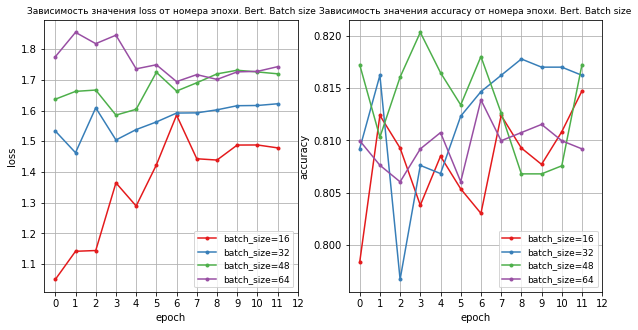

In [ ]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
epch = np.arange(12)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи. Bert. Batch size", fontsize=9)
# for i in range(len(batch_size_list)):
#     plt.plot(epch[i], bs_train_loss[i], marker='.', label=f"batch_size={batch_size_list[i]}")
for i in range(len(batch_size_list)):
    plt.plot(np.arange(12), test_info[i]['test_loss'], marker='.', label=f"batch_size={batch_size_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize=9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи. Bert. Batch size", fontsize=9)
for i in range(len(batch_size_list)):
    plt.plot(np.arange(12), test_info[i]['test_accuracy'], marker='.', label=f"batch_size={batch_size_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(loc='lower right', fontsize=9)
plt.show()

## Вывод:


Видим, что как и написано в документации к данной сети, с дефолтными параметрами batch_size = 32 подходит лучше всего. Будем далее использовать его.

# Tokenizer max length

Оформим функции для удобства

In [48]:
#!g1.1
def get_tokenizer(sentences, labels, max_size):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_size,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation=True
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

In [65]:
#!g1.1

def get_loaders(input_ids, attention_masks, labels, bs):
    train_and_val_size = int(0.8 * len(input_ids))
    train_size = int(0.8 * train_and_val_size)
    val_size = train_and_val_size - train_size
    test_size = len(input_ids) - train_and_val_size

    train_dataset = TensorDataset(input_ids[:train_size], 
                                  attention_masks[:train_size], 
                                  labels[:train_size])

    val_dataset = TensorDataset(input_ids[train_size + 1:train_and_val_size ], 
                                attention_masks[train_size + 1:train_and_val_size], 
                                labels[train_size + 1:train_and_val_size])

    test_dataset = TensorDataset(input_ids[train_and_val_size + 1:], 
                                 attention_masks[train_and_val_size + 1:], 
                                 labels[train_and_val_size + 1:])

    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = bs # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = bs # Evaluate with this batch size.
            )

    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = bs # Evaluate with this batch size.
            )
    return train_dataloader, validation_dataloader, test_dataloader

In [50]:
#!g1.1
import warnings
warnings.filterwarnings("ignore")
max_l = [20, 40, 60, 80]

test_info = []
epochs = 12

for lenn in max_l:
    print(f'TOKENIZER MAX LENGTH = {lenn}')
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    sentences = df['text'].to_list()
    labels = df['airline_sentiment'].to_list()
    input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                   labels, lenn)
    train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                           attention_masks, 
                                                                           labels)
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

TOKENIZER MAX LENGTH = 20


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:18.

  Average training loss: 0.70
  Training epcoh took: 0:00:24

Running Validation...


  8%|▊         | 1/12 [00:25<04:38, 25.35s/it]

  Accuracy: 0.75
  Validation Loss: 0.62
  Validation took: 0:00:02

======== Epoch 2 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:18.

  Average training loss: 0.48
  Training epcoh took: 0:00:23

Running Validation...


 17%|█▋        | 2/12 [00:50<04:10, 25.03s/it]

  Accuracy: 0.76
  Validation Loss: 0.61
  Validation took: 0:00:02

======== Epoch 3 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:11.
  Batch   120  of    160.    Elapsed: 0:00:17.

  Average training loss: 0.35
  Training epcoh took: 0:00:23

Running Validation...


 25%|██▌       | 3/12 [01:14<03:42, 24.72s/it]

  Accuracy: 0.76
  Validation Loss: 0.65
  Validation took: 0:00:02

======== Epoch 4 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:11.
  Batch   120  of    160.    Elapsed: 0:00:17.

  Average training loss: 0.22
  Training epcoh took: 0:00:23

Running Validation...


 33%|███▎      | 4/12 [01:39<03:17, 24.67s/it]

  Accuracy: 0.76
  Validation Loss: 0.72
  Validation took: 0:00:02

======== Epoch 5 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:17.

  Average training loss: 0.15
  Training epcoh took: 0:00:23

Running Validation...


 42%|████▏     | 5/12 [02:03<02:52, 24.71s/it]

  Accuracy: 0.77
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 6 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:18.

  Average training loss: 0.09
  Training epcoh took: 0:00:23

Running Validation...


 50%|█████     | 6/12 [02:28<02:28, 24.82s/it]

  Accuracy: 0.76
  Validation Loss: 1.05
  Validation took: 0:00:02

======== Epoch 7 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:18.

  Average training loss: 0.06
  Training epcoh took: 0:00:24

Running Validation...


 58%|█████▊    | 7/12 [02:54<02:04, 24.97s/it]

  Accuracy: 0.75
  Validation Loss: 1.19
  Validation took: 0:00:02

======== Epoch 8 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:18.

  Average training loss: 0.04
  Training epcoh took: 0:00:24

Running Validation...


 67%|██████▋   | 8/12 [03:19<01:40, 25.22s/it]

  Accuracy: 0.76
  Validation Loss: 1.21
  Validation took: 0:00:02

======== Epoch 9 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:17.

  Average training loss: 0.03
  Training epcoh took: 0:00:23

Running Validation...


 75%|███████▌  | 9/12 [03:44<01:15, 25.04s/it]

  Accuracy: 0.76
  Validation Loss: 1.29
  Validation took: 0:00:02

======== Epoch 10 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:17.

  Average training loss: 0.02
  Training epcoh took: 0:00:23

Running Validation...


 83%|████████▎ | 10/12 [04:09<00:50, 25.03s/it]

  Accuracy: 0.76
  Validation Loss: 1.36
  Validation took: 0:00:02

======== Epoch 11 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:18.

  Average training loss: 0.02
  Training epcoh took: 0:00:24

Running Validation...


 92%|█████████▏| 11/12 [04:35<00:25, 25.18s/it]

  Accuracy: 0.76
  Validation Loss: 1.38
  Validation took: 0:00:02

======== Epoch 12 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:06.
  Batch    80  of    160.    Elapsed: 0:00:12.
  Batch   120  of    160.    Elapsed: 0:00:17.

  Average training loss: 0.02
  Training epcoh took: 0:00:23

Running Validation...


100%|██████████| 12/12 [04:59<00:00, 24.99s/it]

  Accuracy: 0.76
  Validation Loss: 1.38
  Validation took: 0:00:02

Training complete!
Total training took 0:05:00 (h:mm:ss)
TOKENIZER MAX LENGTH = 40



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


======== Epoch 1 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.63
  Training epcoh took: 0:00:39

Running Validation...


  8%|▊         | 1/12 [00:42<07:44, 42.20s/it]

  Accuracy: 0.81
  Validation Loss: 0.50
  Validation took: 0:00:03

======== Epoch 2 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.39
  Training epcoh took: 0:00:39

Running Validation...


 17%|█▋        | 2/12 [01:24<07:00, 42.01s/it]

  Accuracy: 0.81
  Validation Loss: 0.47
  Validation took: 0:00:03

======== Epoch 3 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.24
  Training epcoh took: 0:00:39

Running Validation...


 25%|██▌       | 3/12 [02:05<06:16, 41.84s/it]

  Accuracy: 0.80
  Validation Loss: 0.61
  Validation took: 0:00:03

======== Epoch 4 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.15
  Training epcoh took: 0:00:38

Running Validation...


 33%|███▎      | 4/12 [02:47<05:33, 41.69s/it]

  Accuracy: 0.80
  Validation Loss: 0.68
  Validation took: 0:00:03

======== Epoch 5 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.10
  Training epcoh took: 0:00:38

Running Validation...


 42%|████▏     | 5/12 [03:28<04:51, 41.60s/it]

  Accuracy: 0.80
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 6 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.06
  Training epcoh took: 0:00:38

Running Validation...


 50%|█████     | 6/12 [04:10<04:09, 41.57s/it]

  Accuracy: 0.80
  Validation Loss: 0.87
  Validation took: 0:00:03

======== Epoch 7 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.04
  Training epcoh took: 0:00:38

Running Validation...


 58%|█████▊    | 7/12 [04:51<03:27, 41.56s/it]

  Accuracy: 0.80
  Validation Loss: 0.92
  Validation took: 0:00:03

======== Epoch 8 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.03
  Training epcoh took: 0:00:38

Running Validation...


 67%|██████▋   | 8/12 [05:33<02:46, 41.55s/it]

  Accuracy: 0.79
  Validation Loss: 1.02
  Validation took: 0:00:03

======== Epoch 9 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.02
  Training epcoh took: 0:00:38

Running Validation...


 75%|███████▌  | 9/12 [06:14<02:04, 41.53s/it]

  Accuracy: 0.80
  Validation Loss: 1.05
  Validation took: 0:00:03

======== Epoch 10 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.02
  Training epcoh took: 0:00:38

Running Validation...


 83%|████████▎ | 10/12 [06:56<01:23, 41.51s/it]

  Accuracy: 0.80
  Validation Loss: 1.07
  Validation took: 0:00:03

======== Epoch 11 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.02
  Training epcoh took: 0:00:38

Running Validation...


 92%|█████████▏| 11/12 [07:37<00:41, 41.49s/it]

  Accuracy: 0.80
  Validation Loss: 1.09
  Validation took: 0:00:03

======== Epoch 12 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:10.
  Batch    80  of    160.    Elapsed: 0:00:19.
  Batch   120  of    160.    Elapsed: 0:00:29.

  Average training loss: 0.01
  Training epcoh took: 0:00:38

Running Validation...


100%|██████████| 12/12 [08:19<00:00, 41.59s/it]

  Accuracy: 0.80
  Validation Loss: 1.10
  Validation took: 0:00:03

Training complete!
Total training took 0:08:19 (h:mm:ss)
TOKENIZER MAX LENGTH = 60



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


======== Epoch 1 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.63
  Training epcoh took: 0:00:55

Running Validation...


  8%|▊         | 1/12 [00:59<10:53, 59.40s/it]

  Accuracy: 0.81
  Validation Loss: 0.51
  Validation took: 0:00:05

======== Epoch 2 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.38
  Training epcoh took: 0:00:54

Running Validation...


 17%|█▋        | 2/12 [01:58<09:51, 59.16s/it]

  Accuracy: 0.82
  Validation Loss: 0.46
  Validation took: 0:00:05

======== Epoch 3 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.24
  Training epcoh took: 0:00:54

Running Validation...


 25%|██▌       | 3/12 [02:57<08:51, 59.07s/it]

  Accuracy: 0.80
  Validation Loss: 0.61
  Validation took: 0:00:05

======== Epoch 4 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.15
  Training epcoh took: 0:00:54

Running Validation...


 33%|███▎      | 4/12 [03:56<07:52, 59.07s/it]

  Accuracy: 0.81
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 5 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.09
  Training epcoh took: 0:00:55

Running Validation...


 42%|████▏     | 5/12 [04:55<06:53, 59.13s/it]

  Accuracy: 0.81
  Validation Loss: 0.73
  Validation took: 0:00:05

======== Epoch 6 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.06
  Training epcoh took: 0:00:54

Running Validation...


 50%|█████     | 6/12 [05:54<05:54, 59.08s/it]

  Accuracy: 0.80
  Validation Loss: 0.91
  Validation took: 0:00:05

======== Epoch 7 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.03
  Training epcoh took: 0:00:55

Running Validation...


 58%|█████▊    | 7/12 [06:53<04:55, 59.15s/it]

  Accuracy: 0.80
  Validation Loss: 0.92
  Validation took: 0:00:05

======== Epoch 8 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.02
  Training epcoh took: 0:00:55

Running Validation...


 67%|██████▋   | 8/12 [07:53<03:56, 59.17s/it]

  Accuracy: 0.80
  Validation Loss: 0.99
  Validation took: 0:00:05

======== Epoch 9 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.02
  Training epcoh took: 0:00:55

Running Validation...


 75%|███████▌  | 9/12 [08:52<02:57, 59.19s/it]

  Accuracy: 0.80
  Validation Loss: 1.03
  Validation took: 0:00:05

======== Epoch 10 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.01
  Training epcoh took: 0:00:55

Running Validation...


 83%|████████▎ | 10/12 [09:51<01:58, 59.18s/it]

  Accuracy: 0.80
  Validation Loss: 1.07
  Validation took: 0:00:05

======== Epoch 11 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.01
  Training epcoh took: 0:00:54

Running Validation...


 92%|█████████▏| 11/12 [10:50<00:59, 59.16s/it]

  Accuracy: 0.81
  Validation Loss: 1.08
  Validation took: 0:00:05

======== Epoch 12 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.01
  Training epcoh took: 0:00:54

Running Validation...


100%|██████████| 12/12 [11:49<00:00, 59.13s/it]

  Accuracy: 0.80
  Validation Loss: 1.11
  Validation took: 0:00:05

Training complete!
Total training took 0:11:50 (h:mm:ss)
TOKENIZER MAX LENGTH = 80



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


======== Epoch 1 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.63
  Training epcoh took: 0:01:08

Running Validation...


  8%|▊         | 1/12 [01:13<13:32, 73.84s/it]

  Accuracy: 0.78
  Validation Loss: 0.53
  Validation took: 0:00:06

======== Epoch 2 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.38
  Training epcoh took: 0:01:08

Running Validation...


 17%|█▋        | 2/12 [02:27<12:20, 74.01s/it]

  Accuracy: 0.81
  Validation Loss: 0.47
  Validation took: 0:00:06

======== Epoch 3 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.25
  Training epcoh took: 0:01:08

Running Validation...


 25%|██▌       | 3/12 [03:41<11:06, 74.01s/it]

  Accuracy: 0.80
  Validation Loss: 0.61
  Validation took: 0:00:06

======== Epoch 4 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.15
  Training epcoh took: 0:01:08

Running Validation...


 33%|███▎      | 4/12 [04:55<09:51, 73.95s/it]

  Accuracy: 0.80
  Validation Loss: 0.69
  Validation took: 0:00:06

======== Epoch 5 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.10
  Training epcoh took: 0:01:08

Running Validation...


 42%|████▏     | 5/12 [06:09<08:37, 73.99s/it]

  Accuracy: 0.79
  Validation Loss: 0.81
  Validation took: 0:00:06

======== Epoch 6 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.07
  Training epcoh took: 0:01:08

Running Validation...


 50%|█████     | 6/12 [07:23<07:24, 74.01s/it]

  Accuracy: 0.80
  Validation Loss: 0.89
  Validation took: 0:00:06

======== Epoch 7 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.04
  Training epcoh took: 0:01:08

Running Validation...


 58%|█████▊    | 7/12 [08:37<06:10, 74.02s/it]

  Accuracy: 0.80
  Validation Loss: 0.94
  Validation took: 0:00:06

======== Epoch 8 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.03
  Training epcoh took: 0:01:08

Running Validation...


 67%|██████▋   | 8/12 [09:52<04:56, 74.02s/it]

  Accuracy: 0.81
  Validation Loss: 0.96
  Validation took: 0:00:06

======== Epoch 9 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.02
  Training epcoh took: 0:01:08

Running Validation...


 75%|███████▌  | 9/12 [11:05<03:41, 74.00s/it]

  Accuracy: 0.81
  Validation Loss: 1.03
  Validation took: 0:00:06

======== Epoch 10 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.02
  Training epcoh took: 0:01:08

Running Validation...


 83%|████████▎ | 10/12 [12:19<02:27, 73.99s/it]

  Accuracy: 0.80
  Validation Loss: 1.07
  Validation took: 0:00:06

======== Epoch 11 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.02
  Training epcoh took: 0:01:08

Running Validation...


 92%|█████████▏| 11/12 [13:34<01:14, 74.03s/it]

  Accuracy: 0.80
  Validation Loss: 1.08
  Validation took: 0:00:06

======== Epoch 12 / 12 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:17.
  Batch    80  of    160.    Elapsed: 0:00:34.
  Batch   120  of    160.    Elapsed: 0:00:51.

  Average training loss: 0.01
  Training epcoh took: 0:01:08

Running Validation...


100%|██████████| 12/12 [14:48<00:00, 74.01s/it]

  Accuracy: 0.81
  Validation Loss: 1.09
  Validation took: 0:00:06

Training complete!
Total training took 0:14:48 (h:mm:ss)


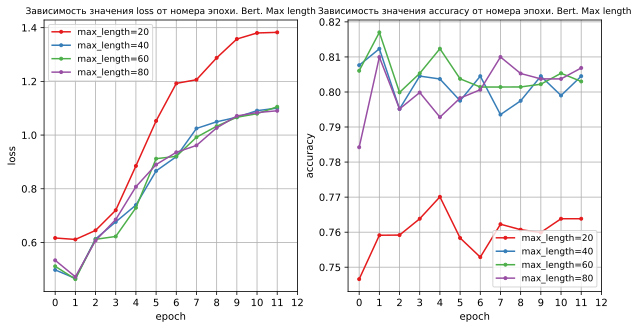

In [51]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
epch = np.arange(12)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи. Bert. Max length", fontsize=9)
for i in range(len(max_l)):
    plt.plot(np.arange(12), test_info[i]['test_loss'], marker='.', label=f"max_length={max_l[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize=9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи. Bert. Max length", fontsize=9)
for i in range(len(max_l)):
    plt.plot(np.arange(12), test_info[i]['test_accuracy'], marker='.', label=f"max_length={max_l[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(loc='lower right', fontsize=9)
plt.show()

## Вывод:

Можно заметить, что везде происходит переобучение, необходимо контроллировать число эпох, поэтому далее мы уменьшим его до 5. Среди значение максимальной длины токенизации 40, 60 и 80 показывают примерно одинаковый результат, но можно заметить по логам из обучения, что чем больше это число, тем дольше модель тартит времени на 1 эпоху, возмем оптимальное значение 60.

# Learning rate

In [52]:
sentences = df['text'].to_list()
labels = df['airline_sentiment'].to_list()
input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                  labels, 60)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels)

In [56]:
import warnings
warnings.filterwarnings("ignore")
lr_list = [5e-3, 5e-4, 5e-5]

test_info = []
epochs = 5

for lr in lr_list:
    print(f'LEARNING RATE = {lr}')
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

LEARNING RATE = 0.005


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:26.
  Batch   120  of    160.    Elapsed: 0:00:39.

  Average training loss: 1.22
  Training epcoh took: 0:00:53

Running Validation...


 20%|██        | 1/5 [00:56<03:46, 56.73s/it]

  Accuracy: 0.47
  Validation Loss: 1.56
  Validation took: 0:00:04

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:40.

  Average training loss: 1.07
  Training epcoh took: 0:00:53

Running Validation...


 40%|████      | 2/5 [01:54<02:51, 57.15s/it]

  Accuracy: 0.47
  Validation Loss: 1.13
  Validation took: 0:00:04

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:40.

  Average training loss: 1.00
  Training epcoh took: 0:00:54

Running Validation...


 60%|██████    | 3/5 [02:52<01:55, 57.55s/it]

  Accuracy: 0.47
  Validation Loss: 1.17
  Validation took: 0:00:04

======== Epoch 4 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 1.01
  Training epcoh took: 0:00:54

Running Validation...


 80%|████████  | 4/5 [03:50<00:57, 57.88s/it]

  Accuracy: 0.47
  Validation Loss: 1.19
  Validation took: 0:00:04

======== Epoch 5 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.94
  Training epcoh took: 0:00:54

Running Validation...


100%|██████████| 5/5 [04:48<00:00, 57.80s/it]

  Accuracy: 0.47
  Validation Loss: 1.14
  Validation took: 0:00:04

Training complete!
Total training took 0:04:49 (h:mm:ss)
LEARNING RATE = 0.0005



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.95
  Training epcoh took: 0:00:54

Running Validation...


 20%|██        | 1/5 [00:58<03:54, 58.67s/it]

  Accuracy: 0.47
  Validation Loss: 1.13
  Validation took: 0:00:04

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.94
  Training epcoh took: 0:00:54

Running Validation...


 40%|████      | 2/5 [01:57<02:55, 58.58s/it]

  Accuracy: 0.47
  Validation Loss: 1.11
  Validation took: 0:00:04

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.93
  Training epcoh took: 0:00:54

Running Validation...


 60%|██████    | 3/5 [02:55<01:57, 58.68s/it]

  Accuracy: 0.47
  Validation Loss: 1.11
  Validation took: 0:00:04

======== Epoch 4 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.93
  Training epcoh took: 0:00:54

Running Validation...


 80%|████████  | 4/5 [03:54<00:58, 58.62s/it]

  Accuracy: 0.47
  Validation Loss: 1.10
  Validation took: 0:00:04

======== Epoch 5 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.93
  Training epcoh took: 0:00:54

Running Validation...


100%|██████████| 5/5 [04:53<00:00, 58.67s/it]

  Accuracy: 0.47
  Validation Loss: 1.11
  Validation took: 0:00:04

Training complete!
Total training took 0:04:53 (h:mm:ss)
LEARNING RATE = 5e-05



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.55
  Training epcoh took: 0:00:54

Running Validation...


 20%|██        | 1/5 [00:59<03:56, 59.14s/it]

  Accuracy: 0.81
  Validation Loss: 0.48
  Validation took: 0:00:05

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.30
  Training epcoh took: 0:00:55

Running Validation...


 40%|████      | 2/5 [01:58<02:57, 59.28s/it]

  Accuracy: 0.80
  Validation Loss: 0.53
  Validation took: 0:00:05

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.14
  Training epcoh took: 0:00:55

Running Validation...


 60%|██████    | 3/5 [02:57<01:58, 59.28s/it]

  Accuracy: 0.81
  Validation Loss: 0.70
  Validation took: 0:00:05

======== Epoch 4 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.06
  Training epcoh took: 0:00:55

Running Validation...


 80%|████████  | 4/5 [03:57<00:59, 59.26s/it]

  Accuracy: 0.79
  Validation Loss: 0.85
  Validation took: 0:00:05

======== Epoch 5 / 5 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.03
  Training epcoh took: 0:00:54

Running Validation...


100%|██████████| 5/5 [04:56<00:00, 59.22s/it]

  Accuracy: 0.81
  Validation Loss: 0.91
  Validation took: 0:00:05

Training complete!
Total training took 0:04:56 (h:mm:ss)


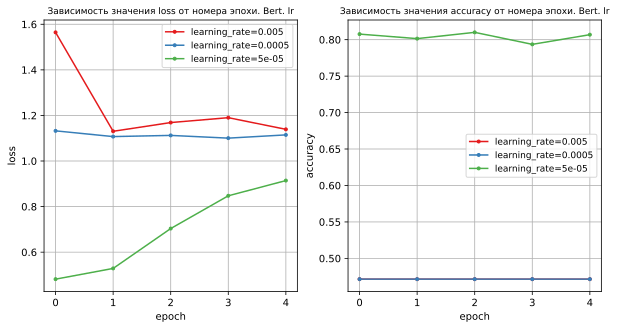

In [64]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
epch = np.arange(5)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи. Bert. lr", fontsize=9)
for i in range(len(lr_list)):
    plt.plot(np.arange(5), test_info[i]['test_loss'], marker='.', label=f"learning_rate={lr_list[i]}")
plt.grid(True)
plt.legend(fontsize=9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи. Bert. lr", fontsize=9)
for i in range(len(lr_list)):
    plt.plot(np.arange(5), test_info[i]['test_accuracy'], marker='.', label=f"learning_rate={lr_list[i]}")
plt.grid(True)
plt.legend(loc='center right', fontsize=9)
plt.show()

## Вывод:

Слишком большой шаг не стоит брать, так как с ним наша сеть очень плохо обучается. Мы перепрыгиваем через минимумы функции потерь. Возьмем learning_rate=5e-05

# Итоговое сравнение

In [69]:
res = []
test_info = []
epochs = 13

#Base
print(f"Base model:")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 64)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 32)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

print(f"Result model:")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 60)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 32)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

Base model:


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:26.
  Batch   120  of    160.    Elapsed: 0:00:39.

  Average training loss: 0.62
  Training epcoh took: 0:00:52

Running Validation...


  8%|▊         | 1/13 [00:57<11:30, 57.58s/it]

  Accuracy: 0.79
  Validation Loss: 0.55
  Validation took: 0:00:05

======== Epoch 2 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:40.

  Average training loss: 0.37
  Training epcoh took: 0:00:54

Running Validation...


 15%|█▌        | 2/13 [01:57<10:45, 58.68s/it]

  Accuracy: 0.80
  Validation Loss: 0.54
  Validation took: 0:00:06

======== Epoch 3 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.24
  Training epcoh took: 0:00:55

Running Validation...


 23%|██▎       | 3/13 [02:57<09:55, 59.54s/it]

  Accuracy: 0.77
  Validation Loss: 0.73
  Validation took: 0:00:06

======== Epoch 4 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.15
  Training epcoh took: 0:00:55

Running Validation...


 31%|███       | 4/13 [03:58<09:01, 60.15s/it]

  Accuracy: 0.79
  Validation Loss: 0.76
  Validation took: 0:00:06

======== Epoch 5 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.09
  Training epcoh took: 0:00:56

Running Validation...


 38%|███▊      | 5/13 [05:00<08:05, 60.69s/it]

  Accuracy: 0.78
  Validation Loss: 0.90
  Validation took: 0:00:06

======== Epoch 6 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.06
  Training epcoh took: 0:00:56

Running Validation...


 46%|████▌     | 6/13 [06:02<07:08, 61.16s/it]

  Accuracy: 0.80
  Validation Loss: 0.99
  Validation took: 0:00:06

======== Epoch 7 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.04
  Training epcoh took: 0:00:56

Running Validation...


 54%|█████▍    | 7/13 [07:04<06:08, 61.46s/it]

  Accuracy: 0.81
  Validation Loss: 1.00
  Validation took: 0:00:06

======== Epoch 8 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.03
  Training epcoh took: 0:00:56

Running Validation...


 62%|██████▏   | 8/13 [08:06<05:08, 61.68s/it]

  Accuracy: 0.79
  Validation Loss: 1.06
  Validation took: 0:00:06

======== Epoch 9 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.02
  Training epcoh took: 0:00:56

Running Validation...


 69%|██████▉   | 9/13 [09:08<04:07, 61.78s/it]

  Accuracy: 0.79
  Validation Loss: 1.20
  Validation took: 0:00:06

======== Epoch 10 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.01
  Training epcoh took: 0:00:56

Running Validation...


 77%|███████▋  | 10/13 [10:10<03:05, 61.84s/it]

  Accuracy: 0.79
  Validation Loss: 1.22
  Validation took: 0:00:06

======== Epoch 11 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.01
  Training epcoh took: 0:00:56

Running Validation...


 85%|████████▍ | 11/13 [11:12<02:03, 61.88s/it]

  Accuracy: 0.80
  Validation Loss: 1.21
  Validation took: 0:00:06

======== Epoch 12 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.01
  Training epcoh took: 0:00:56

Running Validation...


 92%|█████████▏| 12/13 [12:14<01:01, 61.92s/it]

  Accuracy: 0.80
  Validation Loss: 1.23
  Validation took: 0:00:06

======== Epoch 13 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:28.
  Batch   120  of    160.    Elapsed: 0:00:42.

  Average training loss: 0.01
  Training epcoh took: 0:00:56

Running Validation...


100%|██████████| 13/13 [13:16<00:00, 61.28s/it]

  Accuracy: 0.80
  Validation Loss: 1.23
  Validation took: 0:00:06

Training complete!
Total training took 0:13:17 (h:mm:ss)
Result model:



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a


======== Epoch 1 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:13.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.57
  Training epcoh took: 0:00:54

Running Validation...


  8%|▊         | 1/13 [01:00<12:00, 60.07s/it]

  Accuracy: 0.79
  Validation Loss: 0.55
  Validation took: 0:00:06

======== Epoch 2 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.31
  Training epcoh took: 0:00:54

Running Validation...


 15%|█▌        | 2/13 [02:00<11:02, 60.18s/it]

  Accuracy: 0.78
  Validation Loss: 0.62
  Validation took: 0:00:06

======== Epoch 3 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.14
  Training epcoh took: 0:00:55

Running Validation...


 23%|██▎       | 3/13 [03:00<10:03, 60.33s/it]

  Accuracy: 0.79
  Validation Loss: 0.79
  Validation took: 0:00:06

======== Epoch 4 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.07
  Training epcoh took: 0:00:55

Running Validation...


 31%|███       | 4/13 [04:01<09:03, 60.42s/it]

  Accuracy: 0.80
  Validation Loss: 1.02
  Validation took: 0:00:06

======== Epoch 5 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.06
  Training epcoh took: 0:00:54

Running Validation...


 38%|███▊      | 5/13 [05:01<08:02, 60.37s/it]

  Accuracy: 0.79
  Validation Loss: 1.02
  Validation took: 0:00:06

======== Epoch 6 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.04
  Training epcoh took: 0:00:55

Running Validation...


 46%|████▌     | 6/13 [06:02<07:02, 60.36s/it]

  Accuracy: 0.79
  Validation Loss: 1.21
  Validation took: 0:00:06

======== Epoch 7 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.02
  Training epcoh took: 0:00:55

Running Validation...


 54%|█████▍    | 7/13 [07:02<06:02, 60.41s/it]

  Accuracy: 0.78
  Validation Loss: 1.34
  Validation took: 0:00:06

======== Epoch 8 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.01
  Training epcoh took: 0:00:55

Running Validation...


 62%|██████▏   | 8/13 [08:03<05:02, 60.50s/it]

  Accuracy: 0.79
  Validation Loss: 1.42
  Validation took: 0:00:06

======== Epoch 9 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.01
  Training epcoh took: 0:00:55

Running Validation...


 69%|██████▉   | 9/13 [09:03<04:02, 60.51s/it]

  Accuracy: 0.79
  Validation Loss: 1.46
  Validation took: 0:00:06

======== Epoch 10 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.01
  Training epcoh took: 0:00:55

Running Validation...


 77%|███████▋  | 10/13 [10:04<03:01, 60.55s/it]

  Accuracy: 0.79
  Validation Loss: 1.52
  Validation took: 0:00:06

======== Epoch 11 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.01
  Training epcoh took: 0:00:55

Running Validation...


 85%|████████▍ | 11/13 [11:04<02:01, 60.55s/it]

  Accuracy: 0.79
  Validation Loss: 1.53
  Validation took: 0:00:06

======== Epoch 12 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.00
  Training epcoh took: 0:00:55

Running Validation...


 92%|█████████▏| 12/13 [12:05<01:00, 60.59s/it]

  Accuracy: 0.79
  Validation Loss: 1.54
  Validation took: 0:00:06

======== Epoch 13 / 13 ========
Training...
  Batch    40  of    160.    Elapsed: 0:00:14.
  Batch    80  of    160.    Elapsed: 0:00:27.
  Batch   120  of    160.    Elapsed: 0:00:41.

  Average training loss: 0.00
  Training epcoh took: 0:00:55

Running Validation...


100%|██████████| 13/13 [13:05<00:00, 60.46s/it]

  Accuracy: 0.79
  Validation Loss: 1.54
  Validation took: 0:00:06

Training complete!
Total training took 0:13:06 (h:mm:ss)


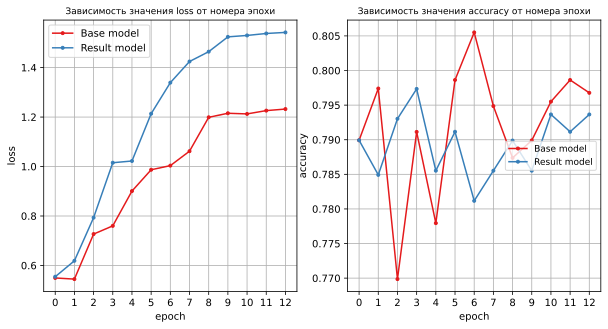

In [70]:
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи", fontsize=9)

plt.plot(np.arange(13), res[0]['test_loss'], marker='.', label=f"Base model")
plt.plot(np.arange(13), res[1]['test_loss'], marker='.', label=f"Result model")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend()

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи", fontsize=9)
plt.plot(np.arange(13), res[0]['test_accuracy'], marker='.', label=f"Base model")
plt.plot(np.arange(13), res[1]['test_accuracy'], marker='.', label=f"Result model")
plt.grid(True)
plt.xticks(np.arange(0, 13, 1))
plt.legend(fontsize=9, loc='center right')
plt.show()

## Выводы:

Заметим, что практически все параметры при подборе лучшего значения совпали с дефолтным (или находятся не так далеко от него), поэтому точность модели не возросла. Возможно, мы взяли слишком мало эпох или маленький датасет (произошло переобучение на нем).

# ALBERT

## Архитектура сети

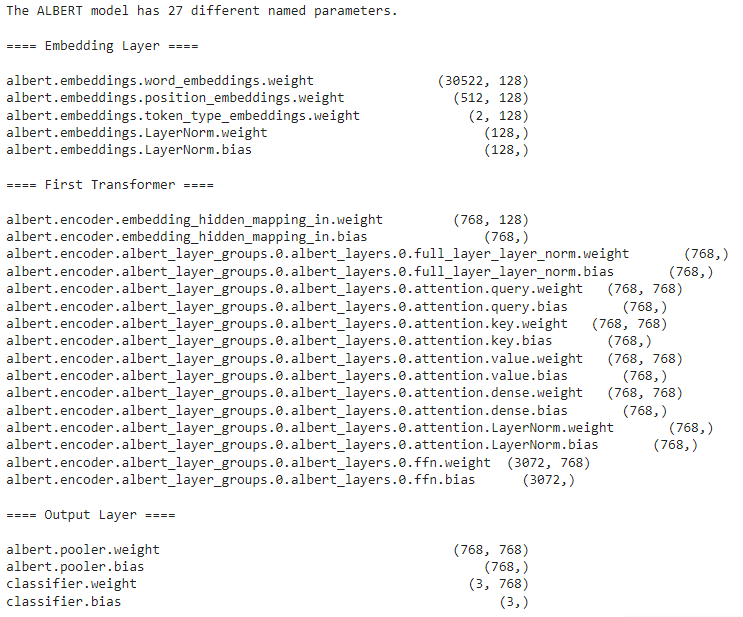

In [ ]:
model = AlbertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias', 

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=76

In [ ]:
params = list(model.named_parameters())

print('The ALBERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The ALBERT model has 27 different named parameters.

==== Embedding Layer ====

albert.embeddings.word_embeddings.weight                (30522, 128)
albert.embeddings.position_embeddings.weight              (512, 128)
albert.embeddings.token_type_embeddings.weight              (2, 128)
albert.embeddings.LayerNorm.weight                            (128,)
albert.embeddings.LayerNorm.bias                              (128,)

==== First Transformer ====

albert.encoder.embedding_hidden_mapping_in.weight         (768, 128)
albert.encoder.embedding_hidden_mapping_in.bias               (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight   (768, 768)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias       (768,)
albert.encoder.albert_layer_groups.0.albert

В этот раз возьмем выборку чуть поменьше и побольше эпох, так как она чуть медленнее обучается. (запускала BERT на датасете такого же размера)

# Batch size

In [ ]:
sentences = df['text'].to_list()
labels = df['airline_sentiment'].to_list()
input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                  labels, 64)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
batch_size_list = [16, 32, 64]

test_info = []
epochs = 17

for bs in batch_size_list:
    print(f'BATCH SIZE = {bs}')
    model = AlbertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, bs)
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

BATCH SIZE = 16


You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias', 


======== Epoch 1 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:06.
  Batch    80  of    200.    Elapsed: 0:00:12.
  Batch   120  of    200.    Elapsed: 0:00:18.
  Batch   160  of    200.    Elapsed: 0:00:25.

  Average training loss: 0.86
  Training epcoh took: 0:00:31

Running Validation...


  6%|▌         | 1/17 [00:33<09:01, 33.84s/it]

  Accuracy: 0.68
  Validation Loss: 0.79
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:06.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:19.
  Batch   160  of    200.    Elapsed: 0:00:26.

  Average training loss: 0.76
  Training epcoh took: 0:00:32

Running Validation...


 12%|█▏        | 2/17 [01:08<08:39, 34.61s/it]

  Accuracy: 0.66
  Validation Loss: 0.86
  Validation took: 0:00:03

======== Epoch 3 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:06.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:19.
  Batch   160  of    200.    Elapsed: 0:00:26.

  Average training loss: 0.71
  Training epcoh took: 0:00:33

Running Validation...


 18%|█▊        | 3/17 [01:44<08:12, 35.18s/it]

  Accuracy: 0.71
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 4 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.60
  Training epcoh took: 0:00:34

Running Validation...


 24%|██▎       | 4/17 [02:22<07:47, 35.97s/it]

  Accuracy: 0.72
  Validation Loss: 0.79
  Validation took: 0:00:03

======== Epoch 5 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.55
  Training epcoh took: 0:00:34

Running Validation...


 29%|██▉       | 5/17 [02:58<07:15, 36.30s/it]

  Accuracy: 0.72
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 6 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.50
  Training epcoh took: 0:00:34

Running Validation...


 35%|███▌      | 6/17 [03:35<06:41, 36.47s/it]

  Accuracy: 0.73
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 7 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.49
  Training epcoh took: 0:00:34

Running Validation...


 41%|████      | 7/17 [04:12<06:06, 36.60s/it]

  Accuracy: 0.73
  Validation Loss: 0.71
  Validation took: 0:00:03

======== Epoch 8 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.44
  Training epcoh took: 0:00:34

Running Validation...


 47%|████▋     | 8/17 [04:49<05:30, 36.70s/it]

  Accuracy: 0.71
  Validation Loss: 0.75
  Validation took: 0:00:03

======== Epoch 9 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.40
  Training epcoh took: 0:00:34

Running Validation...


 53%|█████▎    | 9/17 [05:26<04:54, 36.79s/it]

  Accuracy: 0.72
  Validation Loss: 0.77
  Validation took: 0:00:03

======== Epoch 10 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.38
  Training epcoh took: 0:00:34

Running Validation...


 59%|█████▉    | 10/17 [06:03<04:17, 36.85s/it]

  Accuracy: 0.73
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 11 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.35
  Training epcoh took: 0:00:34

Running Validation...


 65%|██████▍   | 11/17 [06:40<03:41, 36.87s/it]

  Accuracy: 0.72
  Validation Loss: 0.86
  Validation took: 0:00:03

======== Epoch 12 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.32
  Training epcoh took: 0:00:34

Running Validation...


 71%|███████   | 12/17 [07:17<03:04, 36.88s/it]

  Accuracy: 0.71
  Validation Loss: 0.79
  Validation took: 0:00:03

======== Epoch 13 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.30
  Training epcoh took: 0:00:34

Running Validation...


 76%|███████▋  | 13/17 [07:54<02:27, 36.88s/it]

  Accuracy: 0.74
  Validation Loss: 0.88
  Validation took: 0:00:03

======== Epoch 14 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.27
  Training epcoh took: 0:00:34

Running Validation...


 82%|████████▏ | 14/17 [08:31<01:50, 36.89s/it]

  Accuracy: 0.73
  Validation Loss: 0.83
  Validation took: 0:00:03

======== Epoch 15 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.26
  Training epcoh took: 0:00:34

Running Validation...


 88%|████████▊ | 15/17 [09:07<01:13, 36.89s/it]

  Accuracy: 0.72
  Validation Loss: 0.82
  Validation took: 0:00:03

======== Epoch 16 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.23
  Training epcoh took: 0:00:34

Running Validation...


 94%|█████████▍| 16/17 [09:44<00:36, 36.89s/it]

  Accuracy: 0.72
  Validation Loss: 0.91
  Validation took: 0:00:03

======== Epoch 17 / 17 ========
Training...
  Batch    40  of    200.    Elapsed: 0:00:07.
  Batch    80  of    200.    Elapsed: 0:00:13.
  Batch   120  of    200.    Elapsed: 0:00:20.
  Batch   160  of    200.    Elapsed: 0:00:27.

  Average training loss: 0.22
  Training epcoh took: 0:00:34

Running Validation...


100%|██████████| 17/17 [10:21<00:00, 36.57s/it]

  Accuracy: 0.72
  Validation Loss: 0.90
  Validation took: 0:00:03

Training complete!
Total training took 0:10:22 (h:mm:ss)
BATCH SIZE = 32



You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias',


======== Epoch 1 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.87
  Training epcoh took: 0:00:31

Running Validation...


  6%|▌         | 1/17 [00:33<08:57, 33.58s/it]

  Accuracy: 0.65
  Validation Loss: 0.86
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.76
  Training epcoh took: 0:00:31

Running Validation...


 12%|█▏        | 2/17 [01:07<08:24, 33.64s/it]

  Accuracy: 0.67
  Validation Loss: 0.83
  Validation took: 0:00:03

======== Epoch 3 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.71
  Training epcoh took: 0:00:31

Running Validation...


 18%|█▊        | 3/17 [01:41<07:51, 33.69s/it]

  Accuracy: 0.71
  Validation Loss: 0.79
  Validation took: 0:00:03

======== Epoch 4 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.64
  Training epcoh took: 0:00:31

Running Validation...


 24%|██▎       | 4/17 [02:14<07:18, 33.72s/it]

  Accuracy: 0.73
  Validation Loss: 0.67
  Validation took: 0:00:03

======== Epoch 5 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.60
  Training epcoh took: 0:00:31

Running Validation...


 29%|██▉       | 5/17 [02:48<06:45, 33.75s/it]

  Accuracy: 0.73
  Validation Loss: 0.69
  Validation took: 0:00:03

======== Epoch 6 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.57
  Training epcoh took: 0:00:31

Running Validation...


 35%|███▌      | 6/17 [03:22<06:11, 33.74s/it]

  Accuracy: 0.73
  Validation Loss: 0.71
  Validation took: 0:00:03

======== Epoch 7 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.51
  Training epcoh took: 0:00:31

Running Validation...


 41%|████      | 7/17 [03:55<05:37, 33.72s/it]

  Accuracy: 0.72
  Validation Loss: 0.77
  Validation took: 0:00:03

======== Epoch 8 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.49
  Training epcoh took: 0:00:31

Running Validation...


 47%|████▋     | 8/17 [04:29<05:03, 33.70s/it]

  Accuracy: 0.72
  Validation Loss: 0.68
  Validation took: 0:00:03

======== Epoch 9 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.46
  Training epcoh took: 0:00:31

Running Validation...


 53%|█████▎    | 9/17 [05:03<04:29, 33.69s/it]

  Accuracy: 0.74
  Validation Loss: 0.69
  Validation took: 0:00:03

======== Epoch 10 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.43
  Training epcoh took: 0:00:31

Running Validation...


 59%|█████▉    | 10/17 [05:36<03:55, 33.67s/it]

  Accuracy: 0.74
  Validation Loss: 0.69
  Validation took: 0:00:03

======== Epoch 11 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.41
  Training epcoh took: 0:00:31

Running Validation...


 65%|██████▍   | 11/17 [06:10<03:22, 33.70s/it]

  Accuracy: 0.72
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 12 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.39
  Training epcoh took: 0:00:31

Running Validation...


 71%|███████   | 12/17 [06:44<02:48, 33.70s/it]

  Accuracy: 0.71
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 13 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.38
  Training epcoh took: 0:00:31

Running Validation...


 76%|███████▋  | 13/17 [07:18<02:14, 33.68s/it]

  Accuracy: 0.73
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 14 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.34
  Training epcoh took: 0:00:31

Running Validation...


 82%|████████▏ | 14/17 [07:51<01:40, 33.66s/it]

  Accuracy: 0.73
  Validation Loss: 0.75
  Validation took: 0:00:03

======== Epoch 15 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.34
  Training epcoh took: 0:00:31

Running Validation...


 88%|████████▊ | 15/17 [08:25<01:07, 33.67s/it]

  Accuracy: 0.72
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 16 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.32
  Training epcoh took: 0:00:31

Running Validation...


 94%|█████████▍| 16/17 [08:59<00:33, 33.70s/it]

  Accuracy: 0.73
  Validation Loss: 0.75
  Validation took: 0:00:03

======== Epoch 17 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.31
  Training epcoh took: 0:00:31

Running Validation...


100%|██████████| 17/17 [09:32<00:00, 33.70s/it]

  Accuracy: 0.73
  Validation Loss: 0.76
  Validation took: 0:00:03

Training complete!
Total training took 0:09:33 (h:mm:ss)
BATCH SIZE = 64



You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias',


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.88
  Training epcoh took: 0:00:31

Running Validation...


  6%|▌         | 1/17 [00:33<08:57, 33.62s/it]

  Accuracy: 0.68
  Validation Loss: 0.83
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.79
  Training epcoh took: 0:00:31

Running Validation...


 12%|█▏        | 2/17 [01:07<08:24, 33.61s/it]

  Accuracy: 0.67
  Validation Loss: 0.83
  Validation took: 0:00:03

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.73
  Training epcoh took: 0:00:31

Running Validation...


 18%|█▊        | 3/17 [01:40<07:50, 33.62s/it]

  Accuracy: 0.70
  Validation Loss: 0.75
  Validation took: 0:00:03

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.67
  Training epcoh took: 0:00:31

Running Validation...


 24%|██▎       | 4/17 [02:14<07:17, 33.62s/it]

  Accuracy: 0.71
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.65
  Training epcoh took: 0:00:31

Running Validation...


 29%|██▉       | 5/17 [02:48<06:43, 33.62s/it]

  Accuracy: 0.70
  Validation Loss: 0.82
  Validation took: 0:00:03

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.61
  Training epcoh took: 0:00:31

Running Validation...


 35%|███▌      | 6/17 [03:21<06:10, 33.64s/it]

  Accuracy: 0.71
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.58
  Training epcoh took: 0:00:31

Running Validation...


 41%|████      | 7/17 [03:55<05:36, 33.64s/it]

  Accuracy: 0.74
  Validation Loss: 0.68
  Validation took: 0:00:03

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.55
  Training epcoh took: 0:00:31

Running Validation...


 47%|████▋     | 8/17 [04:29<05:02, 33.65s/it]

  Accuracy: 0.70
  Validation Loss: 0.76
  Validation took: 0:00:03

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.55
  Training epcoh took: 0:00:31

Running Validation...


 53%|█████▎    | 9/17 [05:02<04:29, 33.65s/it]

  Accuracy: 0.74
  Validation Loss: 0.67
  Validation took: 0:00:03

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.49
  Training epcoh took: 0:00:31

Running Validation...


 59%|█████▉    | 10/17 [05:36<03:55, 33.66s/it]

  Accuracy: 0.73
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.51
  Training epcoh took: 0:00:31

Running Validation...


 65%|██████▍   | 11/17 [06:10<03:22, 33.69s/it]

  Accuracy: 0.74
  Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.49
  Training epcoh took: 0:00:31

Running Validation...


 71%|███████   | 12/17 [06:43<02:48, 33.72s/it]

  Accuracy: 0.66
  Validation Loss: 0.76
  Validation took: 0:00:03

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.48
  Training epcoh took: 0:00:31

Running Validation...


 76%|███████▋  | 13/17 [07:17<02:14, 33.74s/it]

  Accuracy: 0.74
  Validation Loss: 0.68
  Validation took: 0:00:03

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.46
  Training epcoh took: 0:00:31

Running Validation...


 82%|████████▏ | 14/17 [07:51<01:41, 33.76s/it]

  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.42
  Training epcoh took: 0:00:31

Running Validation...


 88%|████████▊ | 15/17 [08:25<01:07, 33.72s/it]

  Accuracy: 0.74
  Validation Loss: 0.69
  Validation took: 0:00:03

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.42
  Training epcoh took: 0:00:31

Running Validation...


 94%|█████████▍| 16/17 [08:58<00:33, 33.74s/it]

  Accuracy: 0.74
  Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:25.

  Average training loss: 0.42
  Training epcoh took: 0:00:31

Running Validation...


100%|██████████| 17/17 [09:32<00:00, 33.69s/it]

  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:00:03

Training complete!
Total training took 0:09:33 (h:mm:ss)


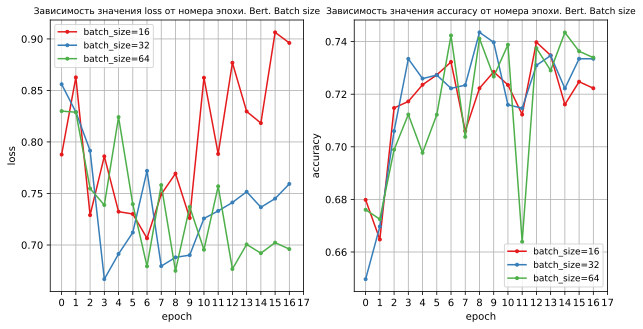

In [ ]:
#!g1.1
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
epch = np.arange(12)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи. Bert. Batch size", fontsize=9)
# for i in range(len(batch_size_list)):
#     plt.plot(epch[i], bs_train_loss[i], marker='.', label=f"batch_size={batch_size_list[i]}")
for i in range(len(batch_size_list)):
    plt.plot(np.arange(17), test_info[i]['test_loss'], marker='.', label=f"batch_size={batch_size_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 18, 1))
plt.legend(fontsize=9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи. Bert. Batch size", fontsize=9)
for i in range(len(batch_size_list)):
    plt.plot(np.arange(17), test_info[i]['test_accuracy'], marker='.', label=f"batch_size={batch_size_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 18, 1))
plt.legend(loc='lower right', fontsize=9)
plt.show()

Заметим, что при размере батча 16 и 32 происходит переобучение, поэтому возьмем для дальнейших экспериментов batch_size=16.

# Tokenizer max length

In [ ]:
import warnings
warnings.filterwarnings("ignore")
max_l = [40, 60, 80]

test_info = []
epochs = 17

for lenn in max_l:
    print(f'TOKENIZER MAX LENGTH = {lenn}')
    model = AlbertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    sentences = df['text'].to_list()
    labels = df['airline_sentiment'].to_list()
    input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, lenn)
    train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                           attention_masks, 
                                                                           labels, 64)
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

TOKENIZER MAX LENGTH = 40


You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias', 


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:14.

  Average training loss: 0.88
  Training epcoh took: 0:00:18

Running Validation...


  6%|▌         | 1/17 [00:19<05:10, 19.43s/it]

  Accuracy: 0.67
  Validation Loss: 0.87
  Validation took: 0:00:02

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:14.

  Average training loss: 0.80
  Training epcoh took: 0:00:18

Running Validation...


 12%|█▏        | 2/17 [00:39<04:54, 19.63s/it]

  Accuracy: 0.69
  Validation Loss: 0.77
  Validation took: 0:00:02

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.73
  Training epcoh took: 0:00:18

Running Validation...


 18%|█▊        | 3/17 [00:59<04:38, 19.89s/it]

  Accuracy: 0.68
  Validation Loss: 0.76
  Validation took: 0:00:02

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.67
  Training epcoh took: 0:00:19

Running Validation...


 24%|██▎       | 4/17 [01:19<04:21, 20.14s/it]

  Accuracy: 0.70
  Validation Loss: 0.76
  Validation took: 0:00:02

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.64
  Training epcoh took: 0:00:19

Running Validation...


 29%|██▉       | 5/17 [01:40<04:05, 20.48s/it]

  Accuracy: 0.70
  Validation Loss: 0.82
  Validation took: 0:00:02

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.62
  Training epcoh took: 0:00:19

Running Validation...


 35%|███▌      | 6/17 [02:02<03:48, 20.77s/it]

  Accuracy: 0.73
  Validation Loss: 0.69
  Validation took: 0:00:02

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.59
  Training epcoh took: 0:00:19

Running Validation...


 41%|████      | 7/17 [02:23<03:28, 20.90s/it]

  Accuracy: 0.73
  Validation Loss: 0.66
  Validation took: 0:00:02

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.55
  Training epcoh took: 0:00:19

Running Validation...


 47%|████▋     | 8/17 [02:44<03:08, 20.92s/it]

  Accuracy: 0.72
  Validation Loss: 0.70
  Validation took: 0:00:02

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.52
  Training epcoh took: 0:00:19

Running Validation...


 53%|█████▎    | 9/17 [03:05<02:47, 20.95s/it]

  Accuracy: 0.73
  Validation Loss: 0.66
  Validation took: 0:00:02

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.50
  Training epcoh took: 0:00:19

Running Validation...


 59%|█████▉    | 10/17 [03:26<02:26, 20.98s/it]

  Accuracy: 0.70
  Validation Loss: 0.69
  Validation took: 0:00:02

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.49
  Training epcoh took: 0:00:19

Running Validation...


 65%|██████▍   | 11/17 [03:47<02:06, 21.02s/it]

  Accuracy: 0.73
  Validation Loss: 0.74
  Validation took: 0:00:02

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.47
  Training epcoh took: 0:00:19

Running Validation...


 71%|███████   | 12/17 [04:08<01:45, 21.02s/it]

  Accuracy: 0.71
  Validation Loss: 0.68
  Validation took: 0:00:02

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.46
  Training epcoh took: 0:00:19

Running Validation...


 76%|███████▋  | 13/17 [04:29<01:24, 21.02s/it]

  Accuracy: 0.74
  Validation Loss: 0.67
  Validation took: 0:00:02

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.44
  Training epcoh took: 0:00:19

Running Validation...


 82%|████████▏ | 14/17 [04:50<01:03, 21.02s/it]

  Accuracy: 0.73
  Validation Loss: 0.68
  Validation took: 0:00:02

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.44
  Training epcoh took: 0:00:19

Running Validation...


 88%|████████▊ | 15/17 [05:11<00:42, 21.00s/it]

  Accuracy: 0.74
  Validation Loss: 0.68
  Validation took: 0:00:02

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.42
  Training epcoh took: 0:00:19

Running Validation...


 94%|█████████▍| 16/17 [05:32<00:21, 21.00s/it]

  Accuracy: 0.74
  Validation Loss: 0.69
  Validation took: 0:00:02

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:15.

  Average training loss: 0.40
  Training epcoh took: 0:00:19

Running Validation...


100%|██████████| 17/17 [05:53<00:00, 20.80s/it]

  Accuracy: 0.74
  Validation Loss: 0.69
  Validation took: 0:00:02

Training complete!
Total training took 0:05:54 (h:mm:ss)
TOKENIZER MAX LENGTH = 60



You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias',


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.88
  Training epcoh took: 0:00:29

Running Validation...


  6%|▌         | 1/17 [00:31<08:23, 31.49s/it]

  Accuracy: 0.67
  Validation Loss: 0.84
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.79
  Training epcoh took: 0:00:29

Running Validation...


 12%|█▏        | 2/17 [01:03<07:52, 31.52s/it]

  Accuracy: 0.69
  Validation Loss: 0.80
  Validation took: 0:00:03

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.73
  Training epcoh took: 0:00:29

Running Validation...


 18%|█▊        | 3/17 [01:34<07:19, 31.40s/it]

  Accuracy: 0.69
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.68
  Training epcoh took: 0:00:29

Running Validation...


 24%|██▎       | 4/17 [02:05<06:48, 31.41s/it]

  Accuracy: 0.70
  Validation Loss: 0.79
  Validation took: 0:00:03

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.64
  Training epcoh took: 0:00:29

Running Validation...


 29%|██▉       | 5/17 [02:37<06:17, 31.44s/it]

  Accuracy: 0.72
  Validation Loss: 0.71
  Validation took: 0:00:03

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.63
  Training epcoh took: 0:00:29

Running Validation...


 35%|███▌      | 6/17 [03:08<05:45, 31.44s/it]

  Accuracy: 0.72
  Validation Loss: 0.68
  Validation took: 0:00:03

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.60
  Training epcoh took: 0:00:29

Running Validation...


 41%|████      | 7/17 [03:40<05:14, 31.43s/it]

  Accuracy: 0.73
  Validation Loss: 0.69
  Validation took: 0:00:03

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.56
  Training epcoh took: 0:00:29

Running Validation...


 47%|████▋     | 8/17 [04:11<04:42, 31.41s/it]

  Accuracy: 0.72
  Validation Loss: 0.74
  Validation took: 0:00:03

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.54
  Training epcoh took: 0:00:29

Running Validation...


 53%|█████▎    | 9/17 [04:42<04:11, 31.39s/it]

  Accuracy: 0.73
  Validation Loss: 0.69
  Validation took: 0:00:03

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.54
  Training epcoh took: 0:00:29

Running Validation...


 59%|█████▉    | 10/17 [05:14<03:39, 31.37s/it]

  Accuracy: 0.72
  Validation Loss: 0.75
  Validation took: 0:00:03

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.50
  Training epcoh took: 0:00:29

Running Validation...


 65%|██████▍   | 11/17 [05:45<03:08, 31.35s/it]

  Accuracy: 0.73
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.48
  Training epcoh took: 0:00:29

Running Validation...


 71%|███████   | 12/17 [06:16<02:36, 31.33s/it]

  Accuracy: 0.72
  Validation Loss: 0.69
  Validation took: 0:00:03

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.46
  Training epcoh took: 0:00:29

Running Validation...


 76%|███████▋  | 13/17 [06:48<02:05, 31.34s/it]

  Accuracy: 0.74
  Validation Loss: 0.71
  Validation took: 0:00:03

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.45
  Training epcoh took: 0:00:29

Running Validation...


 82%|████████▏ | 14/17 [07:19<01:34, 31.36s/it]

  Accuracy: 0.72
  Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.43
  Training epcoh took: 0:00:29

Running Validation...


 88%|████████▊ | 15/17 [07:50<01:02, 31.38s/it]

  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.42
  Training epcoh took: 0:00:29

Running Validation...


 94%|█████████▍| 16/17 [08:22<00:31, 31.39s/it]

  Accuracy: 0.74
  Validation Loss: 0.71
  Validation took: 0:00:03

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.41
  Training epcoh took: 0:00:29

Running Validation...


100%|██████████| 17/17 [08:53<00:00, 31.40s/it]

  Accuracy: 0.74
  Validation Loss: 0.70
  Validation took: 0:00:03

Training complete!
Total training took 0:08:54 (h:mm:ss)
TOKENIZER MAX LENGTH = 80



You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias',


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.88
  Training epcoh took: 0:00:38

Running Validation...


  6%|▌         | 1/17 [00:41<10:59, 41.19s/it]

  Accuracy: 0.68
  Validation Loss: 0.83
  Validation took: 0:00:04

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.79
  Training epcoh took: 0:00:38

Running Validation...


 12%|█▏        | 2/17 [01:22<10:16, 41.07s/it]

  Accuracy: 0.68
  Validation Loss: 0.78
  Validation took: 0:00:03

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.74
  Training epcoh took: 0:00:37

Running Validation...


 18%|█▊        | 3/17 [02:03<09:34, 41.03s/it]

  Accuracy: 0.70
  Validation Loss: 0.73
  Validation took: 0:00:04

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.67
  Training epcoh took: 0:00:38

Running Validation...


 24%|██▎       | 4/17 [02:44<08:53, 41.06s/it]

  Accuracy: 0.71
  Validation Loss: 0.71
  Validation took: 0:00:04

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.65
  Training epcoh took: 0:00:38

Running Validation...


 29%|██▉       | 5/17 [03:25<08:13, 41.09s/it]

  Accuracy: 0.71
  Validation Loss: 0.76
  Validation took: 0:00:04

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.60
  Training epcoh took: 0:00:38

Running Validation...


 35%|███▌      | 6/17 [04:06<07:32, 41.12s/it]

  Accuracy: 0.72
  Validation Loss: 0.72
  Validation took: 0:00:04

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.59
  Training epcoh took: 0:00:38

Running Validation...


 41%|████      | 7/17 [04:47<06:51, 41.14s/it]

  Accuracy: 0.74
  Validation Loss: 0.70
  Validation took: 0:00:04

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.55
  Training epcoh took: 0:00:38

Running Validation...


 47%|████▋     | 8/17 [05:28<06:10, 41.16s/it]

  Accuracy: 0.71
  Validation Loss: 0.76
  Validation took: 0:00:04

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.54
  Training epcoh took: 0:00:38

Running Validation...


 53%|█████▎    | 9/17 [06:10<05:29, 41.16s/it]

  Accuracy: 0.75
  Validation Loss: 0.67
  Validation took: 0:00:04

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.50
  Training epcoh took: 0:00:38

Running Validation...


 59%|█████▉    | 10/17 [06:51<04:48, 41.16s/it]

  Accuracy: 0.73
  Validation Loss: 0.76
  Validation took: 0:00:04

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.50
  Training epcoh took: 0:00:38

Running Validation...


 65%|██████▍   | 11/17 [07:32<04:06, 41.16s/it]

  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:00:04

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.48
  Training epcoh took: 0:00:38

Running Validation...


 71%|███████   | 12/17 [08:13<03:25, 41.17s/it]

  Accuracy: 0.70
  Validation Loss: 0.71
  Validation took: 0:00:04

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.46
  Training epcoh took: 0:00:38

Running Validation...


 76%|███████▋  | 13/17 [08:54<02:44, 41.16s/it]

  Accuracy: 0.74
  Validation Loss: 0.71
  Validation took: 0:00:04

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.44
  Training epcoh took: 0:00:38

Running Validation...


 82%|████████▏ | 14/17 [09:35<02:03, 41.16s/it]

  Accuracy: 0.74
  Validation Loss: 0.71
  Validation took: 0:00:04

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.42
  Training epcoh took: 0:00:38

Running Validation...


 88%|████████▊ | 15/17 [10:17<01:22, 41.17s/it]

  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:00:04

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.42
  Training epcoh took: 0:00:38

Running Validation...


 94%|█████████▍| 16/17 [10:58<00:41, 41.17s/it]

  Accuracy: 0.74
  Validation Loss: 0.69
  Validation took: 0:00:04

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:30.

  Average training loss: 0.41
  Training epcoh took: 0:00:38

Running Validation...


100%|██████████| 17/17 [11:39<00:00, 41.15s/it]

  Accuracy: 0.75
  Validation Loss: 0.70
  Validation took: 0:00:04

Training complete!
Total training took 0:11:39 (h:mm:ss)


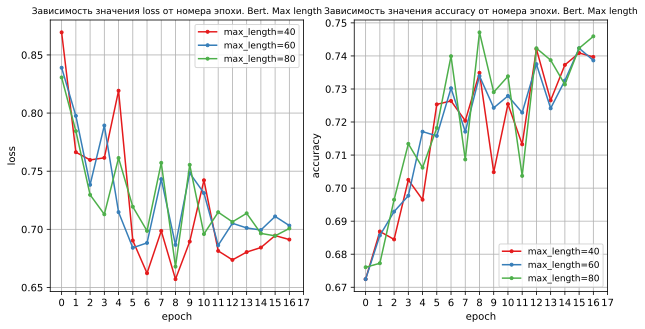

In [ ]:
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
epch = np.arange(17)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи. Bert. Max length", fontsize=9)
for i in range(len(max_l)):
    plt.plot(np.arange(17), test_info[i]['test_loss'], marker='.', label=f"max_length={max_l[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 18, 1))
plt.legend(fontsize=9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи. Bert. Max length", fontsize=9)
for i in range(len(max_l)):
    plt.plot(np.arange(17), test_info[i]['test_accuracy'], marker='.', label=f"max_length={max_l[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 18, 1))
plt.legend(loc='lower right', fontsize=9)
plt.show()

## Вывод:


Здесь все значения максимальной длины токенизации ведут себя примерно одинаково, возьмем среднее из них - 60 

# Learning rate

In [ ]:
lr_list = [5e-3, 5e-4, 5e-5]

test_info = []
epochs = 17

for lr in lr_list:
    print(f'LEARNING RATE = {lr}')
    model = AlbertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3,  
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda()
    
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    test_data = train(train_dataloader, validation_dataloader, epochs,
                     optimizer, scheduler, model)
    test_info.append(test_data)

LEARNING RATE = 0.005


You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias', 


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 1.42
  Training epcoh took: 0:00:28

Running Validation...


  6%|▌         | 1/17 [00:30<08:14, 30.90s/it]

  Accuracy: 0.65
  Validation Loss: 1.06
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 1.06
  Training epcoh took: 0:00:29

Running Validation...


 12%|█▏        | 2/17 [01:02<07:47, 31.16s/it]

  Accuracy: 0.65
  Validation Loss: 0.98
  Validation took: 0:00:02

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:22.

  Average training loss: 1.19
  Training epcoh took: 0:00:28

Running Validation...


 18%|█▊        | 3/17 [01:32<07:11, 30.83s/it]

  Accuracy: 0.65
  Validation Loss: 1.14
  Validation took: 0:00:02

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.97
  Training epcoh took: 0:00:28

Running Validation...


 24%|██▎       | 4/17 [02:03<06:40, 30.78s/it]

  Accuracy: 0.65
  Validation Loss: 0.99
  Validation took: 0:00:02

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.96
  Training epcoh took: 0:00:28

Running Validation...


 29%|██▉       | 5/17 [02:34<06:09, 30.80s/it]

  Accuracy: 0.65
  Validation Loss: 0.94
  Validation took: 0:00:02

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.96
  Training epcoh took: 0:00:28

Running Validation...


 35%|███▌      | 6/17 [03:04<05:37, 30.73s/it]

  Accuracy: 0.65
  Validation Loss: 0.98
  Validation took: 0:00:02

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 1.00
  Training epcoh took: 0:00:28

Running Validation...


 41%|████      | 7/17 [03:35<05:07, 30.71s/it]

  Accuracy: 0.65
  Validation Loss: 1.05
  Validation took: 0:00:02

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.99
  Training epcoh took: 0:00:28

Running Validation...


 47%|████▋     | 8/17 [04:06<04:36, 30.72s/it]

  Accuracy: 0.65
  Validation Loss: 0.90
  Validation took: 0:00:02

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.93
  Training epcoh took: 0:00:28

Running Validation...


 53%|█████▎    | 9/17 [04:36<04:05, 30.73s/it]

  Accuracy: 0.65
  Validation Loss: 1.05
  Validation took: 0:00:02

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.97
  Training epcoh took: 0:00:28

Running Validation...


 59%|█████▉    | 10/17 [05:07<03:35, 30.72s/it]

  Accuracy: 0.65
  Validation Loss: 0.93
  Validation took: 0:00:02

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.95
  Training epcoh took: 0:00:28

Running Validation...


 65%|██████▍   | 11/17 [05:38<03:04, 30.70s/it]

  Accuracy: 0.65
  Validation Loss: 0.95
  Validation took: 0:00:02

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.94
  Training epcoh took: 0:00:28

Running Validation...


 71%|███████   | 12/17 [06:08<02:33, 30.68s/it]

  Accuracy: 0.65
  Validation Loss: 0.92
  Validation took: 0:00:02

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.91
  Training epcoh took: 0:00:28

Running Validation...


 76%|███████▋  | 13/17 [06:39<02:02, 30.65s/it]

  Accuracy: 0.65
  Validation Loss: 0.91
  Validation took: 0:00:02

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.93
  Training epcoh took: 0:00:28

Running Validation...


 82%|████████▏ | 14/17 [07:10<01:31, 30.64s/it]

  Accuracy: 0.65
  Validation Loss: 0.93
  Validation took: 0:00:02

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.92
  Training epcoh took: 0:00:28

Running Validation...


 88%|████████▊ | 15/17 [07:40<01:01, 30.63s/it]

  Accuracy: 0.65
  Validation Loss: 0.95
  Validation took: 0:00:02

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.91
  Training epcoh took: 0:00:28

Running Validation...


 94%|█████████▍| 16/17 [08:11<00:30, 30.64s/it]

  Accuracy: 0.65
  Validation Loss: 0.92
  Validation took: 0:00:02

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:28

Running Validation...


100%|██████████| 17/17 [08:42<00:00, 30.71s/it]

  Accuracy: 0.65
  Validation Loss: 0.88
  Validation took: 0:00:02

Training complete!
Total training took 0:08:42 (h:mm:ss)
LEARNING RATE = 0.0005



You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias',


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 1.10
  Training epcoh took: 0:00:29

Running Validation...


  6%|▌         | 1/17 [00:30<08:15, 31.00s/it]

  Accuracy: 0.65
  Validation Loss: 0.91
  Validation took: 0:00:02

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.91
  Training epcoh took: 0:00:29

Running Validation...


 12%|█▏        | 2/17 [01:01<07:45, 31.00s/it]

  Accuracy: 0.65
  Validation Loss: 0.90
  Validation took: 0:00:02

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 18%|█▊        | 3/17 [01:33<07:14, 31.00s/it]

  Accuracy: 0.65
  Validation Loss: 0.88
  Validation took: 0:00:02

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 24%|██▎       | 4/17 [02:04<06:43, 31.02s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 29%|██▉       | 5/17 [02:35<06:12, 31.03s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 35%|███▌      | 6/17 [03:06<05:41, 31.04s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 41%|████      | 7/17 [03:37<05:10, 31.04s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 47%|████▋     | 8/17 [04:08<04:39, 31.05s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 53%|█████▎    | 9/17 [04:39<04:08, 31.06s/it]

  Accuracy: 0.65
  Validation Loss: 0.88
  Validation took: 0:00:02

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 59%|█████▉    | 10/17 [05:10<03:37, 31.05s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 65%|██████▍   | 11/17 [05:41<03:06, 31.05s/it]

  Accuracy: 0.65
  Validation Loss: 0.88
  Validation took: 0:00:02

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 71%|███████   | 12/17 [06:12<02:35, 31.05s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.89
  Training epcoh took: 0:00:29

Running Validation...


 76%|███████▋  | 13/17 [06:43<02:04, 31.04s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


 82%|████████▏ | 14/17 [07:14<01:33, 31.03s/it]

  Accuracy: 0.65
  Validation Loss: 0.89
  Validation took: 0:00:02

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.89
  Training epcoh took: 0:00:29

Running Validation...


 88%|████████▊ | 15/17 [07:45<01:02, 31.04s/it]

  Accuracy: 0.65
  Validation Loss: 0.88
  Validation took: 0:00:02

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.89
  Training epcoh took: 0:00:29

Running Validation...


 94%|█████████▍| 16/17 [08:16<00:31, 31.04s/it]

  Accuracy: 0.65
  Validation Loss: 0.88
  Validation took: 0:00:02

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.89
  Training epcoh took: 0:00:29

Running Validation...


100%|██████████| 17/17 [08:47<00:00, 31.04s/it]

  Accuracy: 0.65
  Validation Loss: 0.88
  Validation took: 0:00:02

Training complete!
Total training took 0:08:48 (h:mm:ss)
LEARNING RATE = 5e-05



You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias',


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


  6%|▌         | 1/17 [00:31<08:21, 31.34s/it]

  Accuracy: 0.66
  Validation Loss: 0.85
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.80
  Training epcoh took: 0:00:29

Running Validation...


 12%|█▏        | 2/17 [01:02<07:50, 31.37s/it]

  Accuracy: 0.68
  Validation Loss: 0.81
  Validation took: 0:00:03

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.71
  Training epcoh took: 0:00:29

Running Validation...


 18%|█▊        | 3/17 [01:34<07:19, 31.39s/it]

  Accuracy: 0.72
  Validation Loss: 0.68
  Validation took: 0:00:03

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.63
  Training epcoh took: 0:00:29

Running Validation...


 24%|██▎       | 4/17 [02:05<06:48, 31.44s/it]

  Accuracy: 0.73
  Validation Loss: 0.71
  Validation took: 0:00:03

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.55
  Training epcoh took: 0:00:29

Running Validation...


 29%|██▉       | 5/17 [02:37<06:17, 31.47s/it]

  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.49
  Training epcoh took: 0:00:29

Running Validation...


 35%|███▌      | 6/17 [03:08<05:46, 31.48s/it]

  Accuracy: 0.73
  Validation Loss: 0.72
  Validation took: 0:00:03

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.43
  Training epcoh took: 0:00:29

Running Validation...


 41%|████      | 7/17 [03:40<05:14, 31.48s/it]

  Accuracy: 0.74
  Validation Loss: 0.87
  Validation took: 0:00:03

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.45
  Training epcoh took: 0:00:29

Running Validation...


 47%|████▋     | 8/17 [04:11<04:43, 31.51s/it]

  Accuracy: 0.74
  Validation Loss: 0.80
  Validation took: 0:00:03

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.36
  Training epcoh took: 0:00:29

Running Validation...


 53%|█████▎    | 9/17 [04:43<04:12, 31.50s/it]

  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.34
  Training epcoh took: 0:00:29

Running Validation...


 59%|█████▉    | 10/17 [05:14<03:40, 31.51s/it]

  Accuracy: 0.74
  Validation Loss: 0.80
  Validation took: 0:00:03

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.33
  Training epcoh took: 0:00:29

Running Validation...


 65%|██████▍   | 11/17 [05:46<03:09, 31.51s/it]

  Accuracy: 0.74
  Validation Loss: 0.85
  Validation took: 0:00:03

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.29
  Training epcoh took: 0:00:29

Running Validation...


 71%|███████   | 12/17 [06:17<02:37, 31.51s/it]

  Accuracy: 0.73
  Validation Loss: 0.84
  Validation took: 0:00:03

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.26
  Training epcoh took: 0:00:29

Running Validation...


 76%|███████▋  | 13/17 [06:49<02:06, 31.51s/it]

  Accuracy: 0.73
  Validation Loss: 0.85
  Validation took: 0:00:03

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.25
  Training epcoh took: 0:00:29

Running Validation...


 82%|████████▏ | 14/17 [07:20<01:34, 31.49s/it]

  Accuracy: 0.73
  Validation Loss: 0.85
  Validation took: 0:00:03

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.23
  Training epcoh took: 0:00:29

Running Validation...


 88%|████████▊ | 15/17 [07:52<01:02, 31.48s/it]

  Accuracy: 0.73
  Validation Loss: 0.83
  Validation took: 0:00:03

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.21
  Training epcoh took: 0:00:29

Running Validation...


 94%|█████████▍| 16/17 [08:23<00:31, 31.48s/it]

  Accuracy: 0.74
  Validation Loss: 0.88
  Validation took: 0:00:03

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.20
  Training epcoh took: 0:00:29

Running Validation...


100%|██████████| 17/17 [08:55<00:00, 31.48s/it]

  Accuracy: 0.73
  Validation Loss: 0.86
  Validation took: 0:00:03

Training complete!
Total training took 0:08:55 (h:mm:ss)


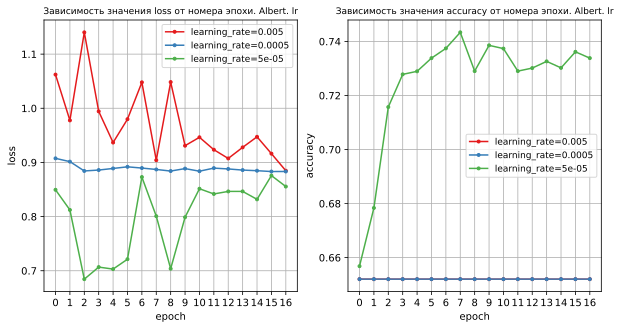

In [ ]:
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
epch = np.arange(17)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи. Albert. lr", fontsize=9)
for i in range(len(lr_list)):
    plt.plot(np.arange(17), test_info[i]['test_loss'], marker='.', label=f"learning_rate={lr_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 17, 1))
plt.legend(fontsize=9)

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи. Albert. lr", fontsize=9)
for i in range(len(lr_list)):
    plt.plot(np.arange(17), test_info[i]['test_accuracy'], marker='.', label=f"learning_rate={lr_list[i]}")
plt.grid(True)
plt.xticks(np.arange(0, 17, 1))
plt.legend(loc='center right', fontsize=9)
plt.show()

# Вывод:


Аналогичная ситуация, как была с Bert-ом, слишком большой шаг нам не подходит, сеть не обучается. Возьмем learning_rate=5e-05

# Итоговое сравнение

In [ ]:
res = []
test_info = []
epochs = 17

#Base
print(f"Base model:")
model = AlbertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 64)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 32)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

print(f"Result model:")

model = AlbertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

input_ids, attention_masks, labels = get_tokenizer(sentences, 
                                                      labels, 60)
train_dataloader, validation_dataloader, test_dataloader = get_loaders(input_ids, 
                                                                        attention_masks, 
                                                                        labels, 64)

model.cuda()

optimizer = AdamW(model.parameters(),
              lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
test_data = train(train_dataloader, test_dataloader, epochs,
                  optimizer, scheduler, model)
res.append(test_data)

Base model:


You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias', 


======== Epoch 1 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:11.
  Batch    80  of    100.    Elapsed: 0:00:23.

  Average training loss: 0.87
  Training epcoh took: 0:00:28

Running Validation...


  6%|▌         | 1/17 [00:31<08:29, 31.86s/it]

  Accuracy: 0.54
  Validation Loss: 1.01
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:23.

  Average training loss: 0.76
  Training epcoh took: 0:00:29

Running Validation...


 12%|█▏        | 2/17 [01:04<08:06, 32.46s/it]

  Accuracy: 0.59
  Validation Loss: 0.98
  Validation took: 0:00:04

======== Epoch 3 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.71
  Training epcoh took: 0:00:30

Running Validation...


 18%|█▊        | 3/17 [01:38<07:44, 33.16s/it]

  Accuracy: 0.64
  Validation Loss: 0.93
  Validation took: 0:00:04

======== Epoch 4 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.64
  Training epcoh took: 0:00:31

Running Validation...


 24%|██▎       | 4/17 [02:13<07:18, 33.73s/it]

  Accuracy: 0.67
  Validation Loss: 0.75
  Validation took: 0:00:04

======== Epoch 5 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.60
  Training epcoh took: 0:00:31

Running Validation...


 29%|██▉       | 5/17 [02:47<06:47, 33.94s/it]

  Accuracy: 0.67
  Validation Loss: 0.76
  Validation took: 0:00:04

======== Epoch 6 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:24.

  Average training loss: 0.57
  Training epcoh took: 0:00:31

Running Validation...


 35%|███▌      | 6/17 [03:21<06:14, 34.07s/it]

  Accuracy: 0.66
  Validation Loss: 0.85
  Validation took: 0:00:04

======== Epoch 7 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.51
  Training epcoh took: 0:00:31

Running Validation...


 41%|████      | 7/17 [03:56<05:41, 34.18s/it]

  Accuracy: 0.66
  Validation Loss: 0.93
  Validation took: 0:00:04

======== Epoch 8 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.49
  Training epcoh took: 0:00:31

Running Validation...


 47%|████▋     | 8/17 [04:30<05:08, 34.27s/it]

  Accuracy: 0.68
  Validation Loss: 0.78
  Validation took: 0:00:04

======== Epoch 9 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.46
  Training epcoh took: 0:00:31

Running Validation...


 53%|█████▎    | 9/17 [05:05<04:34, 34.34s/it]

  Accuracy: 0.69
  Validation Loss: 0.81
  Validation took: 0:00:04

======== Epoch 10 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.43
  Training epcoh took: 0:00:31

Running Validation...


 59%|█████▉    | 10/17 [05:39<04:00, 34.37s/it]

  Accuracy: 0.69
  Validation Loss: 0.80
  Validation took: 0:00:04

======== Epoch 11 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.41
  Training epcoh took: 0:00:31

Running Validation...


 65%|██████▍   | 11/17 [06:14<03:26, 34.40s/it]

  Accuracy: 0.67
  Validation Loss: 0.82
  Validation took: 0:00:04

======== Epoch 12 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.39
  Training epcoh took: 0:00:31

Running Validation...


 71%|███████   | 12/17 [06:48<02:52, 34.41s/it]

  Accuracy: 0.67
  Validation Loss: 0.79
  Validation took: 0:00:04

======== Epoch 13 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.38
  Training epcoh took: 0:00:31

Running Validation...


 76%|███████▋  | 13/17 [07:23<02:17, 34.42s/it]

  Accuracy: 0.70
  Validation Loss: 0.87
  Validation took: 0:00:04

======== Epoch 14 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.34
  Training epcoh took: 0:00:31

Running Validation...


 82%|████████▏ | 14/17 [07:57<01:43, 34.43s/it]

  Accuracy: 0.70
  Validation Loss: 0.86
  Validation took: 0:00:04

======== Epoch 15 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.34
  Training epcoh took: 0:00:31

Running Validation...


 88%|████████▊ | 15/17 [08:32<01:08, 34.43s/it]

  Accuracy: 0.68
  Validation Loss: 0.82
  Validation took: 0:00:04

======== Epoch 16 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.32
  Training epcoh took: 0:00:31

Running Validation...


 94%|█████████▍| 16/17 [09:06<00:34, 34.43s/it]

  Accuracy: 0.69
  Validation Loss: 0.84
  Validation took: 0:00:04

======== Epoch 17 / 17 ========
Training...
  Batch    40  of    100.    Elapsed: 0:00:12.
  Batch    80  of    100.    Elapsed: 0:00:25.

  Average training loss: 0.31
  Training epcoh took: 0:00:31

Running Validation...


100%|██████████| 17/17 [09:40<00:00, 34.17s/it]

  Accuracy: 0.70
  Validation Loss: 0.87
  Validation took: 0:00:04

Training complete!
Total training took 0:09:41 (h:mm:ss)
Result model:



You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.3.intermediate.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias',


======== Epoch 1 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.90
  Training epcoh took: 0:00:29

Running Validation...


  6%|▌         | 1/17 [00:32<08:33, 32.08s/it]

  Accuracy: 0.54
  Validation Loss: 1.05
  Validation took: 0:00:03

======== Epoch 2 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.80
  Training epcoh took: 0:00:29

Running Validation...


 12%|█▏        | 2/17 [01:04<08:01, 32.12s/it]

  Accuracy: 0.57
  Validation Loss: 0.99
  Validation took: 0:00:03

======== Epoch 3 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.71
  Training epcoh took: 0:00:29

Running Validation...


 18%|█▊        | 3/17 [01:36<07:28, 32.05s/it]

  Accuracy: 0.66
  Validation Loss: 0.78
  Validation took: 0:00:03

======== Epoch 4 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.63
  Training epcoh took: 0:00:29

Running Validation...


 24%|██▎       | 4/17 [02:08<06:56, 32.03s/it]

  Accuracy: 0.68
  Validation Loss: 0.82
  Validation took: 0:00:03

======== Epoch 5 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.55
  Training epcoh took: 0:00:29

Running Validation...


 29%|██▉       | 5/17 [02:40<06:24, 32.03s/it]

  Accuracy: 0.67
  Validation Loss: 0.82
  Validation took: 0:00:03

======== Epoch 6 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.49
  Training epcoh took: 0:00:29

Running Validation...


 35%|███▌      | 6/17 [03:12<05:52, 32.04s/it]

  Accuracy: 0.66
  Validation Loss: 0.91
  Validation took: 0:00:03

======== Epoch 7 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.43
  Training epcoh took: 0:00:29

Running Validation...


 41%|████      | 7/17 [03:44<05:20, 32.05s/it]

  Accuracy: 0.66
  Validation Loss: 1.11
  Validation took: 0:00:03

======== Epoch 8 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.45
  Training epcoh took: 0:00:29

Running Validation...


 47%|████▋     | 8/17 [04:16<04:48, 32.06s/it]

  Accuracy: 0.67
  Validation Loss: 1.03
  Validation took: 0:00:03

======== Epoch 9 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.36
  Training epcoh took: 0:00:29

Running Validation...


 53%|█████▎    | 9/17 [04:48<04:16, 32.06s/it]

  Accuracy: 0.69
  Validation Loss: 0.81
  Validation took: 0:00:03

======== Epoch 10 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.34
  Training epcoh took: 0:00:29

Running Validation...


 59%|█████▉    | 10/17 [05:20<03:44, 32.08s/it]

  Accuracy: 0.67
  Validation Loss: 1.00
  Validation took: 0:00:03

======== Epoch 11 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.33
  Training epcoh took: 0:00:29

Running Validation...


 65%|██████▍   | 11/17 [05:52<03:12, 32.08s/it]

  Accuracy: 0.67
  Validation Loss: 1.07
  Validation took: 0:00:03

======== Epoch 12 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.29
  Training epcoh took: 0:00:29

Running Validation...


 71%|███████   | 12/17 [06:24<02:40, 32.08s/it]

  Accuracy: 0.69
  Validation Loss: 1.00
  Validation took: 0:00:03

======== Epoch 13 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.26
  Training epcoh took: 0:00:29

Running Validation...


 76%|███████▋  | 13/17 [06:56<02:08, 32.10s/it]

  Accuracy: 0.69
  Validation Loss: 1.03
  Validation took: 0:00:03

======== Epoch 14 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.25
  Training epcoh took: 0:00:29

Running Validation...


 82%|████████▏ | 14/17 [07:29<01:36, 32.10s/it]

  Accuracy: 0.70
  Validation Loss: 0.98
  Validation took: 0:00:03

======== Epoch 15 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.23
  Training epcoh took: 0:00:29

Running Validation...


 88%|████████▊ | 15/17 [08:01<01:04, 32.10s/it]

  Accuracy: 0.70
  Validation Loss: 0.97
  Validation took: 0:00:03

======== Epoch 16 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.21
  Training epcoh took: 0:00:29

Running Validation...


 94%|█████████▍| 16/17 [08:33<00:32, 32.10s/it]

  Accuracy: 0.70
  Validation Loss: 1.04
  Validation took: 0:00:03

======== Epoch 17 / 17 ========
Training...
  Batch    40  of     50.    Elapsed: 0:00:23.

  Average training loss: 0.20
  Training epcoh took: 0:00:29

Running Validation...


100%|██████████| 17/17 [09:05<00:00, 32.08s/it]

  Accuracy: 0.70
  Validation Loss: 1.00
  Validation took: 0:00:03

Training complete!
Total training took 0:09:05 (h:mm:ss)


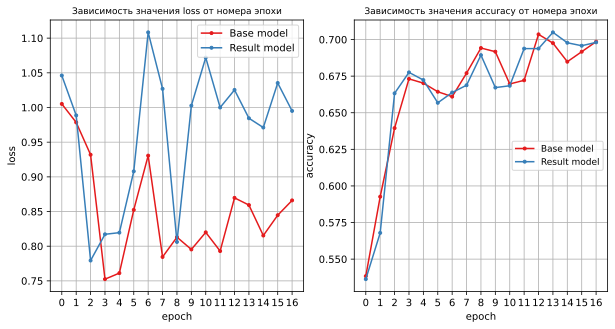

In [ ]:
sns.set_palette("Set1")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Зависимость значения loss от номера эпохи", fontsize=9)

plt.plot(np.arange(17), res[0]['test_loss'], marker='.', label=f"Base model")
plt.plot(np.arange(17), res[1]['test_loss'], marker='.', label=f"Result model")
plt.grid(True)
plt.xticks(np.arange(0, 17, 1))
plt.legend()

ax = fig.add_subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Зависимость значения accuracy от номера эпохи", fontsize=9)
plt.plot(np.arange(17), res[0]['test_accuracy'], marker='.', label=f"Base model")
plt.plot(np.arange(17), res[1]['test_accuracy'], marker='.', label=f"Result model")
plt.grid(True)
plt.xticks(np.arange(0, 17, 1))
plt.legend(fontsize=9, loc='center right')
plt.show()

# Вывод:

Можно сделать вывод опять же из-за небольших отличий в значениях гиперпараметров качество модели не изменилось. Также ,возможно, мы переобучаемся из-за маленького размера датасета.

Или такая ситуация произошла из-за того, что мы не перемешивали датасет перед делением.